# ¿Ha disminuido la concetración de gases tras las restricciones de Madrid Central? 

(Comentar la celda siguiente para ver las lineas de codigo)

In [87]:
# from IPython.display import HTML
# HTML('''<script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Descripción del problema

<img src="madrid_central.png" style="float:right; width: 300px"></img>
El Ayuntamiento de Madrid pone a disposición del ciudadano un catálogo de datos abiertos sobre la ciudad madrileña. 

Utilizando los datos referentes a la [Calidad del Aire](https://datos.madrid.es/portal/site/egob/menuitem.c05c1f754a33a9fbe4b2e4b284f1a5a0/?vgnextoid=f3c0f7d512273410VgnVCM2000000c205a0aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD&vgnextfmt=default)  queremos estudiar si tras las restricciones de tráfico llevadas a cabo en Madrid Central realmente ha disminuido la concentración de Dióxido de Nitrógeno (NO2).

Para ello queremos analizar cómo ha variado la presencia de NO2 en las mediciones realizadas por las estaciones de calidad del aire dentro de Madrid Central, en torno a la fecha en la que se activaron por primera vez las restricciones.

## Análisis

### Generación del dataset

Considerando que Madrid Central entró en vigor el **30 de Noviembre de 2018**, genera el dataset de partida a través de los datos que facilita el Ayuntamiento de Madrid: [Calidad del aire. Datos horarios años 2001 a 2021](https://datos.madrid.es/portal/site/egob/menuitem.c05c1f754a33a9fbe4b2e4b284f1a5a0/?vgnextoid=f3c0f7d512273410VgnVCM2000000c205a0aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD&vgnextfmt=default)

El dataset debe tener en cuenta las siguientes consideraciones:
* nos interesa la zona de Madrid Central, por lo que, sólo debe contener información de aquellas estaciones que se ubiquen dentro de este área. Para este punto puedes apoyarte en los ficheros adicionales de la carpeta `Estaciones`.
* nuestro análisis está centrado en el Dióxido de Nitrógeno, pero también queremos ver la relación con otros gases como: Monóxido de Carbono (CO), Monóxido de Nitrógeno (NO) y Óxidos de Nitrógeno (NOx). Así que podemos reducir el dataset a estas magnitudes.
* partimos del dato diario a nivel horario.

Perfecto! Vamos a cargar los ficheros que se encuentran en el link [Calidad del Aire](https://datos.madrid.es/portal/site/egob/menuitem.c05c1f754a33a9fbe4b2e4b284f1a5a0/?vgnextoid=f3c0f7d512273410VgnVCM2000000c205a0aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD&vgnextfmt=default) en un diccionario organizado por año y mes llamado `downloaded` para poder inspeccionarlos.
El diccionario tendra la estructura {`2001`: {`1`: `<df con datos de enero del 2001>`, `2`: `<df de febrero del 2001>`, `...`, `12`: `<df con datos de dic del  2001>`}, `2002`: {`<idem>`}, `...`, `2023`: {`<idem>`}}

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from datetime import datetime

In [89]:
# Como los archivos descargados tienen una estructura de la nomenclatura similar, 
# podemos definir un bucle para que vaya inspeccionando carpeta carpeta y añadiendo cada archivo a una tabla 

import glob
downloaded = {}

# Define un diccionario donde cada abreviatura de mes se puede relacionar con un entero
month_dict = {'ene': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'jul': 7, 'ago': 8, 
               'sep': 9, 'oct': 10, 'nov': 11, 'dic': 12}

# El bucle:
for year in range(2001, 2024):
    head_folder_name = 'downloaded/'
    sub_folder_name = 'Anio' + str(year) +'/'
    sub_dir = head_folder_name + sub_folder_name
    
    # Initialise a dict that is going to store all of the month data in a given year
    all_months = {}
    for month in month_dict.keys():
        
        month_no = month_dict[month]
        path = sub_dir + '*' + month + '*.csv'
#         df_name = str(year) + '_' + str(month_dict[month])
        files = glob.glob(path)
        if files:  # check if the list is not empty
            month_data = pd.read_csv(files[0], encoding='utf-8', delimiter=';')
            all_months[month_no] = month_data
    downloaded[year] = all_months

In [90]:
downloaded

{2001: {1:       PROVINCIA  MUNICIPIO  ESTACION  MAGNITUD PUNTO_MUESTREO   ANO  MES  DIA  \
  0            28         79         4         1  28079004_1_38  2001    1    1   
  1            28         79         4         1  28079004_1_38  2001    1    2   
  2            28         79         4         1  28079004_1_38  2001    1    3   
  3            28         79         4         1  28079004_1_38  2001    1    4   
  4            28         79         4         1  28079004_1_38  2001    1    5   
  ...         ...        ...       ...       ...            ...   ...  ...  ...   
  2289         28         79        40        12  28079040_12_8  2001    1   27   
  2290         28         79        40        12  28079040_12_8  2001    1   28   
  2291         28         79        40        12  28079040_12_8  2001    1   29   
  2292         28         79        40        12  28079040_12_8  2001    1   30   
  2293         28         79        40        12  28079040_12_8  2001    1   3

Inspeccionando los dataframes, podemos ver que todos tienen una columna para el año, el mes y el dia. Por lo tanto, podemos pasar a utilizar el meto `append` directamente, el cual generara un nuevo dataframe que guardaremos en la variable `combinado`.

In [91]:
list_yearly = []
for year, year_dict in downloaded.items():
    current_year = pd.concat(year_dict.values())
    list_yearly.append(current_year)
combinado = pd.concat(list_yearly)

In [92]:
pd.set_option('display.max_columns', None)
combinado[:5]

,PROVINCIA,MUNICIPIO,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,H01,V01,H02,V02,H03,V03,H04,V04,H05,V05,H06,V06,H07,V07,H08,V08,H09,V09,H10,V10,H11,V11,H12,V12,H13,V13,H14,V14,H15,V15,H16,V16,H17,V17,H18,V18,H19,V19,H20,V20,H21,V21,H22,V22,H23,V23,H24,V24
0,28,79,4,1,28079004_1_38,2001,1,1,21.0,V,23.0,V,25.0,V,22.0,V,22.0,V,15.0,V,14.0,V,14.0,V,14.0,V,14.0,V,17.0,V,16.0,V,17.0,V,19.0,V,20.0,V,16.0,V,14.0,V,15.0,V,14.0,V,13.0,V,14.0,V,16.0,V,15.0,V,13.0,V
1,28,79,4,1,28079004_1_38,2001,1,2,12.0,V,11.0,V,10.0,V,10.0,V,8.0,V,9.0,V,9.0,V,10.0,V,12.0,V,14.0,V,14.0,V,14.0,V,20.0,V,21.0,V,21.0,V,22.0,V,19.0,V,18.0,V,16.0,V,19.0,V,18.0,V,16.0,V,13.0,V,11.0,V
2,28,79,4,1,28079004_1_38,2001,1,3,10.0,V,10.0,V,9.0,V,9.0,V,9.0,V,9.0,V,10.0,V,12.0,V,13.0,V,16.0,V,19.0,V,23.0,V,22.0,V,21.0,V,21.0,V,20.0,V,20.0,V,20.0,V,17.0,V,16.0,V,14.0,V,14.0,V,12.0,V,11.0,V
3,28,79,4,1,28079004_1_38,2001,1,4,10.0,V,8.0,V,8.0,V,8.0,V,7.0,V,7.0,V,8.0,V,10.0,V,11.0,V,11.0,V,14.0,V,18.0,V,20.0,V,19.0,V,21.0,V,22.0,V,22.0,V,22.0,V,20.0,V,19.0,V,20.0,V,19.0,V,17.0,V,15.0,V
4,28,79,4,1,28079004_1_38,2001,1,5,16.0,V,20.0,V,17.0,V,16.0,V,14.0,V,15.0,V,16.0,V,18.0,V,22.0,V,24.0,V,19.0,V,15.0,V,14.0,V,13.0,V,14.0,V,15.0,V,14.0,V,15.0,V,16.0,V,17.0,V,16.0,V,15.0,V,14.0,V,13.0,V


Podemos visualizar también un análisis del dataframe, para asegurarnos de que las variables categóricas y las numerales son correctas.

In [93]:
combinado.describe(include = 'all')

,PROVINCIA,MUNICIPIO,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,H01,V01,H02,V02,H03,V03,H04,V04,H05,V05,H06,V06,H07,V07,H08,V08,H09,V09,H10,V10,H11,V11,H12,V12,H13,V13,H14,V14,H15,V15,H16,V16,H17,V17,H18,V18,H19,V19,H20,V20,H21,V21,H22,V22,H23,V23,H24,V24
count,896460.0,896460.0,896460.000000,896460.000000,896460,896460.000000,896460.000000,896460.000000,896460.000000,896460,896460.000000,896460,896460.000000,896460,896460.000000,896460,896460.000000,896460,896460.000000,896460,896460.000000,896460,896460.000000,896460,896460.000000,896460,896460.000000,896460,896460.000000,896460,896460.000000,896460,896460.000000,896460,896460.000000,896460,896460.000000,896460,896460.000000,896460,896460.00000,896460,896460.000000,896460,896460.000000,896460,896460.000000,896460,896460.000000,896460,896460.000000,896460,896460.000000,896460,896460.000000,896460
unique,NaN,NaN,NaN,NaN,157,NaN,NaN,NaN,NaN,2,NaN,2,NaN,2,NaN,2,NaN,2,NaN,2,NaN,2,NaN,2,NaN,2,NaN,2,NaN,2,NaN,2,NaN,2,NaN,2,NaN,2,NaN,2,NaN,2,NaN,2,NaN,2,NaN,2,NaN,2,NaN,2,NaN,2,NaN,2
top,NaN,NaN,NaN,NaN,28079040_8_8,NaN,NaN,NaN,NaN,V,NaN,V,NaN,V,NaN,V,NaN,V,NaN,V,NaN,V,NaN,V,NaN,V,NaN,V,NaN,V,NaN,V,NaN,V,NaN,V,NaN,V,NaN,V,NaN,V,NaN,V,NaN,V,NaN,V,NaN,V,NaN,V,NaN,V,NaN,V
freq,NaN,NaN,NaN,NaN,7484,NaN,NaN,NaN,NaN,888926,NaN,888885,NaN,886074,NaN,888575,NaN,888515,NaN,888315,NaN,888156,NaN,887552,NaN,885599,NaN,881924,NaN,879688,NaN,879196,NaN,879998,NaN,881279,NaN,885086,NaN,888209,NaN,887742,NaN,887926,NaN,888470,NaN,888685,NaN,889301,NaN,889106,NaN,889321,NaN,889028
mean,28.0,79.0,31.909847,12.999335,NaN,2013.165271,6.687976,15.750425,31.836609,NaN,27.051493,NaN,23.087398,NaN,20.473825,NaN,18.750754,NaN,18.507396,NaN,22.228119,NaN,32.736462,NaN,42.050374,NaN,42.257803,NaN,36.522392,NaN,32.491978,NaN,29.910313,NaN,27.846032,NaN,26.153535,NaN,24.485471,NaN,24.29046,NaN,26.539882,NaN,31.464939,NaN,37.211092,NaN,41.660962,NaN,43.929048,NaN,42.294780,NaN,37.206282,NaN
std,0.0,0.0,17.214269,10.632174,NaN,5.958451,3.527446,8.813052,62.067044,NaN,51.275032,NaN,42.967134,NaN,36.881869,NaN,32.632317,NaN,30.906727,NaN,35.811913,NaN,56.064889,NaN,78.195592,NaN,121.651643,NaN,65.189562,NaN,53.662233,NaN,52.165733,NaN,43.772435,NaN,39.992131,NaN,99.122097,NaN,36.59869,NaN,42.590216,NaN,93.113772,NaN,115.920593,NaN,84.693969,NaN,88.704603,NaN,85.348742,NaN,74.552303,NaN
min,28.0,79.0,4.000000,1.000000,NaN,2001.000000,1.000000,1.000000,-3.000000,NaN,-3.000000,NaN,-3.000000,NaN,-3.000000,NaN,-13.000000,NaN,-3.000000,NaN,-1.000000,NaN,-2.000000,NaN,-1.000000,NaN,-0.350000,NaN,-0.400000,NaN,-1.000000,NaN,-4.000000,NaN,-1.000000,NaN,-1.940000,NaN,-1.000000,NaN,-60.00000,NaN,-8.000000,NaN,-2.000000,NaN,-0.140000,NaN,-28.000000,NaN,-2.000000,NaN,-3.000000,NaN,-1.000000,NaN
25%,28.0,79.0,17.000000,7.000000,NaN,2009.000000,3.000000,8.000000,1.360000,NaN,1.250000,NaN,1.110000,NaN,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.280000,NaN,1.600000,NaN,2.000000,NaN,2.500000,NaN,2.470000,NaN,2.000000,NaN,2.000000,NaN,2.000000,NaN,2.000000,NaN,1.500000,NaN,1.40000,NaN,1.400000,NaN,1.450000,NaN,1.600000,NaN,1.780000,NaN,1.820000,NaN,1.720000,NaN,1.500000,NaN
50%,28.0,79.0,35.000000,10.000000,NaN,2014.000000,7.000000,16.000000,11.000000,NaN,9.000000,NaN,8.000000,NaN,7.000000,NaN,7.000000,NaN,7.000000,NaN,9.000000,NaN,13.000000,NaN,16.000000,NaN,17.000000,NaN,16.000000,NaN,15.000000,NaN,14.000000,NaN,13.000000,NaN,12.000000,NaN,10.000000,NaN,10.00000,NaN,10.000000,NaN,11.000000,NaN,13.000000,NaN,14.000000,NaN,15.000000,NaN,14.000000,NaN,12.000000,NaN
75%,28.0,79.0,48.000000,14.000000,NaN,2018.000000,10.000000,23.000000,38.000000,NaN,33.000000,NaN,28.000000,NaN,25.000000,NaN,23.000000,NaN,24.000000,NaN,30.000000,NaN,43.000000,NaN,52.000000,NaN,51.000000,NaN,46.000000,NaN,43.000000,NaN,40.052500,NaN,38.000000,NaN,35.000000,NaN,32.000000,NaN,31.72000,NaN,35.000000,NaN,40.000000,NaN,45.000000,NaN,50.000000,NaN,52.000000,NaN,49.470000,NaN,44.000000,NaN


### Cargamos el fichero `estaciones`
Este df contiene únicamente datos de Madrid Centro.

In [94]:
estaciones = pd.read_csv('Estaciones/estaciones.csv', encoding='latin1', on_bad_lines='skip', delimiter=';');

El archivo tiene una fila corrupta - c/Jupiter. Hemos añadido un parámetro on_bad_lines = 'skip' en el método read_csv para saltar las líneas que generan un error.

In [95]:
estaciones[:5]

,CODIGO,CODIGO_CORTO,ESTACION,DIRECCION,LONGITUD_ETRS89,LATITUD_ETRS89,ALTITUD,COD_TIPO,NOM_TIPO,NO2,SO2,CO,PM10,PM2_5,O3,BTX,HC,COD_VIA,VIA_CLASE,VIA_PAR,VIA_NOMBRE,Fecha alta,COORDENADA_X_ETRS89,COORDENADA_Y_ETRS89,LONGITUD,LATITUD
0,28079004,4,Pza. de España,Plaza de España,"3°42'43.91""O","40°25'25.98""N",637,UT,Urbana tráfico,X,X,X,NaN,NaN,NaN,NaN,NaN,273600,PLAZA,DE,ESPAÑA,01/12/1998,"439579,3291","4475049,263",-3.712257,40.423882
1,28079008,8,Escuelas Aguirre,Entre C/ Alcalá y C/ O Donell,"3°40'56.22""O","40°25'17.63""N",672,UT,Urbana tráfico,X,X,X,X,X,X,X,X,18900,CALLE,DE,ALCALA,01/12/1998,"442117,2366","4474770,696",-3.682316,40.421553
2,28079011,11,Avda. Ramón y Cajal,Avda. Ramón y Cajal esq. C/ Príncipe de Vergara,"3°40'38.50""O","40°27'5.29""N",708,UT,Urbana tráfico,X,NaN,NaN,NaN,NaN,NaN,X,NaN,610450,CALLE,DEL,PRINCIPE DE VERGARA,01/12/1998,"442564,0457","4478088,595",-3.677349,40.451473
3,28079016,16,Arturo Soria,C/ Arturo Soria esq. C/ Vizconde de los Asilos,"3°38'21.17""O","40°26'24.20""N",695,UF,Urbana fondo,X,NaN,X,NaN,NaN,X,NaN,NaN,798700,CALLE,DEL,VIZCONDE DE LOS ASILOS,01/12/1998,"445786,1729","4476796,019",-3.639242,40.440046
4,28079017,17,Villaverde,C/. Juan Peñalver,"3°42'47.89""O","40°20'49.74""N",601,UF,Urbana fondo,X,X,NaN,NaN,NaN,X,NaN,NaN,417200,CALLE,DE,JUAN PEÑALVER,01/12/1998,"439420,7015","4466532,455",-3.713317,40.347147


### Reducimos la df `combinado` a los resultados de Madrid Central utilizando la df `estaciones`.
Vemos que los dos dataframes tienen una columna en común:
* La columna **CODIGO_CORTO** de `estaciones`, y
* La columna **ESTACION** de `combinado`.
Para ello, generamos una máscara y se la aplicamos a `combinado`, generando una nueva df llamada `central`.
* Habíamos eliminado el récord de la c/Júpiter - sin embargo, por inspección visual, se puede ver que el código de esa estación era `27`, así que lo añadimos manualmente. Los códigos de la columna **CODIGO_CORTO**, junto con el número `27` se guardan en una serie llamada `manual`. Esto no es sostenible para dataframes grandes pero en esta instancia, `estaciones` es un fichero pequeño.

In [96]:
type(estaciones['CODIGO_CORTO'])

pandas.core.series.Series

In [97]:
# Añadimos el 27 a la Series para hacer la mascara
original = estaciones['CODIGO_CORTO']

added = pd.Series([27])

manual = pd.concat([original, added])

# Definimos la máscara
mascara = combinado['ESTACION'].isin(manual)

# Aplicamos la máscara
central = combinado[mascara]
central

,PROVINCIA,MUNICIPIO,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,H01,V01,H02,V02,H03,V03,H04,V04,H05,V05,H06,V06,H07,V07,H08,V08,H09,V09,H10,V10,H11,V11,H12,V12,H13,V13,H14,V14,H15,V15,H16,V16,H17,V17,H18,V18,H19,V19,H20,V20,H21,V21,H22,V22,H23,V23,H24,V24
0,28,79,4,1,28079004_1_38,2001,1,1,21.0,V,23.0,V,25.0,V,22.0,V,22.0,V,15.0,V,14.0,V,14.0,V,14.0,V,14.0,V,17.0,V,16.0,V,17.0,V,19.0,V,20.0,V,16.0,V,14.0,V,15.0,V,14.0,V,13.0,V,14.0,V,16.0,V,15.0,V,13.0,V
1,28,79,4,1,28079004_1_38,2001,1,2,12.0,V,11.0,V,10.0,V,10.0,V,8.0,V,9.0,V,9.0,V,10.0,V,12.0,V,14.0,V,14.0,V,14.0,V,20.0,V,21.0,V,21.0,V,22.0,V,19.0,V,18.0,V,16.0,V,19.0,V,18.0,V,16.0,V,13.0,V,11.0,V
2,28,79,4,1,28079004_1_38,2001,1,3,10.0,V,10.0,V,9.0,V,9.0,V,9.0,V,9.0,V,10.0,V,12.0,V,13.0,V,16.0,V,19.0,V,23.0,V,22.0,V,21.0,V,21.0,V,20.0,V,20.0,V,20.0,V,17.0,V,16.0,V,14.0,V,14.0,V,12.0,V,11.0,V
3,28,79,4,1,28079004_1_38,2001,1,4,10.0,V,8.0,V,8.0,V,8.0,V,7.0,V,7.0,V,8.0,V,10.0,V,11.0,V,11.0,V,14.0,V,18.0,V,20.0,V,19.0,V,21.0,V,22.0,V,22.0,V,22.0,V,20.0,V,19.0,V,20.0,V,19.0,V,17.0,V,15.0,V
4,28,79,4,1,28079004_1_38,2001,1,5,16.0,V,20.0,V,17.0,V,16.0,V,14.0,V,15.0,V,16.0,V,18.0,V,22.0,V,24.0,V,19.0,V,15.0,V,14.0,V,13.0,V,14.0,V,15.0,V,14.0,V,15.0,V,16.0,V,17.0,V,16.0,V,15.0,V,14.0,V,13.0,V
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4086,28,79,60,14,28079060_14_6,2023,5,27,58.0,V,57.0,V,52.0,V,43.0,V,44.0,V,43.0,V,46.0,V,43.0,V,46.0,V,65.0,V,74.0,V,78.0,V,83.0,V,86.0,V,89.0,V,94.0,V,93.0,V,80.0,V,82.0,V,81.0,V,77.0,V,73.0,V,64.0,V,71.0,V
4087,28,79,60,14,28079060_14_6,2023,5,28,75.0,V,67.0,V,64.0,V,54.0,V,56.0,V,57.0,V,60.0,V,57.0,V,60.0,V,66.0,V,70.0,V,75.0,V,82.0,V,79.0,V,77.0,V,88.0,V,97.0,V,86.0,V,92.0,V,86.0,V,77.0,V,69.0,V,65.0,V,59.0,V
4088,28,79,60,14,28079060_14_6,2023,5,29,50.0,V,40.0,V,45.0,V,53.0,V,57.0,V,38.0,V,26.0,V,14.0,V,31.0,V,53.0,V,70.0,V,79.0,V,87.0,V,92.0,V,93.0,V,99.0,V,103.0,V,104.0,V,89.0,V,58.0,V,57.0,V,57.0,V,45.0,V,32.0,V
4089,28,79,60,14,28079060_14_6,2023,5,30,35.0,V,25.0,V,28.0,V,27.0,V,28.0,V,33.0,V,28.0,V,12.0,V,16.0,V,28.0,V,44.0,V,68.0,V,78.0,V,90.0,V,94.0,V,95.0,V,94.0,V,88.0,V,77.0,V,61.0,V,61.0,V,54.0,V,51.0,V,36.0,V


In [98]:
# Incluso nos podemos asegurar de que los códigos en la columna ESTACION de la df `central` solo contienen los valores
# de la columna `estaciones`:

series1 = estaciones['CODIGO_CORTO']

series2 = central['ESTACION']

for i in series1:
    if i not in series2:
        print('error')
# Si esta celda no imprime nada, entonces hemos sido exitosos.

### Limpiamos el dataframe `central`.
#### 1. Nos dehacemos de columnas que no traen informacion nueva:

Parece que las columnas 'PROVINCIA' y 'MUNICIPIO' no proveen ninguna información nueva. Nos aseguramos: Si el output siguiente es 1.0 para un único valor, esas columnas no contienen información.

In [99]:
central['PROVINCIA'].value_counts(normalize=True)

28    1.0
Name: PROVINCIA, dtype: float64

In [100]:
central['MUNICIPIO'].value_counts(normalize=True)

79    1.0
Name: MUNICIPIO, dtype: float64

Nos dehacemos de ellas, junto con **PUNTO_MUESTREO**, que es una concatenacion de otras columnas:

In [101]:
central = central.drop('PROVINCIA', axis = 1)
central = central.drop('MUNICIPIO', axis = 1)
central = central.drop('PUNTO_MUESTREO', axis = 1)

In [102]:
central

,ESTACION,MAGNITUD,ANO,MES,DIA,H01,V01,H02,V02,H03,V03,H04,V04,H05,V05,H06,V06,H07,V07,H08,V08,H09,V09,H10,V10,H11,V11,H12,V12,H13,V13,H14,V14,H15,V15,H16,V16,H17,V17,H18,V18,H19,V19,H20,V20,H21,V21,H22,V22,H23,V23,H24,V24
0,4,1,2001,1,1,21.0,V,23.0,V,25.0,V,22.0,V,22.0,V,15.0,V,14.0,V,14.0,V,14.0,V,14.0,V,17.0,V,16.0,V,17.0,V,19.0,V,20.0,V,16.0,V,14.0,V,15.0,V,14.0,V,13.0,V,14.0,V,16.0,V,15.0,V,13.0,V
1,4,1,2001,1,2,12.0,V,11.0,V,10.0,V,10.0,V,8.0,V,9.0,V,9.0,V,10.0,V,12.0,V,14.0,V,14.0,V,14.0,V,20.0,V,21.0,V,21.0,V,22.0,V,19.0,V,18.0,V,16.0,V,19.0,V,18.0,V,16.0,V,13.0,V,11.0,V
2,4,1,2001,1,3,10.0,V,10.0,V,9.0,V,9.0,V,9.0,V,9.0,V,10.0,V,12.0,V,13.0,V,16.0,V,19.0,V,23.0,V,22.0,V,21.0,V,21.0,V,20.0,V,20.0,V,20.0,V,17.0,V,16.0,V,14.0,V,14.0,V,12.0,V,11.0,V
3,4,1,2001,1,4,10.0,V,8.0,V,8.0,V,8.0,V,7.0,V,7.0,V,8.0,V,10.0,V,11.0,V,11.0,V,14.0,V,18.0,V,20.0,V,19.0,V,21.0,V,22.0,V,22.0,V,22.0,V,20.0,V,19.0,V,20.0,V,19.0,V,17.0,V,15.0,V
4,4,1,2001,1,5,16.0,V,20.0,V,17.0,V,16.0,V,14.0,V,15.0,V,16.0,V,18.0,V,22.0,V,24.0,V,19.0,V,15.0,V,14.0,V,13.0,V,14.0,V,15.0,V,14.0,V,15.0,V,16.0,V,17.0,V,16.0,V,15.0,V,14.0,V,13.0,V
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4086,60,14,2023,5,27,58.0,V,57.0,V,52.0,V,43.0,V,44.0,V,43.0,V,46.0,V,43.0,V,46.0,V,65.0,V,74.0,V,78.0,V,83.0,V,86.0,V,89.0,V,94.0,V,93.0,V,80.0,V,82.0,V,81.0,V,77.0,V,73.0,V,64.0,V,71.0,V
4087,60,14,2023,5,28,75.0,V,67.0,V,64.0,V,54.0,V,56.0,V,57.0,V,60.0,V,57.0,V,60.0,V,66.0,V,70.0,V,75.0,V,82.0,V,79.0,V,77.0,V,88.0,V,97.0,V,86.0,V,92.0,V,86.0,V,77.0,V,69.0,V,65.0,V,59.0,V
4088,60,14,2023,5,29,50.0,V,40.0,V,45.0,V,53.0,V,57.0,V,38.0,V,26.0,V,14.0,V,31.0,V,53.0,V,70.0,V,79.0,V,87.0,V,92.0,V,93.0,V,99.0,V,103.0,V,104.0,V,89.0,V,58.0,V,57.0,V,57.0,V,45.0,V,32.0,V
4089,60,14,2023,5,30,35.0,V,25.0,V,28.0,V,27.0,V,28.0,V,33.0,V,28.0,V,12.0,V,16.0,V,28.0,V,44.0,V,68.0,V,78.0,V,90.0,V,94.0,V,95.0,V,94.0,V,88.0,V,77.0,V,61.0,V,61.0,V,54.0,V,51.0,V,36.0,V


#### 2. Eliminamos las magnitudes que no nos interesan
Según la descripcion del problema, nos enfocamos en:
* Dióxido de Nitrógeno
* Monóxido de Carbono (CO)
* Monóxido de Nitrógeno (NO)
* Óxidos de Nitrógeno (NOx)

De acuerdo con el **ANEXO II** del diccionario de datos en [la web](https://datos.madrid.es/FWProjects/egob/Catalogo/MedioAmbiente/Aire/Ficheros/Interprete_ficheros_%20calidad_%20del_%20aire_global.pdf) , estas substancias se corresponden con lo siguientes numerales de la columna  **MAGNITUD**:

* NO2 <=> `08`
* CO <=> `06`
* NO <=> `07`
* NOx <=> `12`

Guardaré estos valores en una lista llamada `magnitudes_importantes` y eliminaré las filas que no las contengan.


In [103]:
# Creamos la lista cn los índices correctos
magnitudes_importantes = [8, 6, 7, 12]

# Modificamos el df `central`

central = central[central['MAGNITUD'].isin(magnitudes_importantes)]

In [104]:
central

,ESTACION,MAGNITUD,ANO,MES,DIA,H01,V01,H02,V02,H03,V03,H04,V04,H05,V05,H06,V06,H07,V07,H08,V08,H09,V09,H10,V10,H11,V11,H12,V12,H13,V13,H14,V14,H15,V15,H16,V16,H17,V17,H18,V18,H19,V19,H20,V20,H21,V21,H22,V22,H23,V23,H24,V24
31,4,6,2001,1,1,1.1,V,1.8,V,2.4,V,2.1,V,1.7,V,0.6,V,0.4,V,0.5,V,0.5,V,0.5,V,0.5,V,0.5,V,0.5,V,0.6,V,0.8,V,0.5,V,0.3,V,0.6,V,0.6,V,0.6,V,0.7,V,0.5,V,0.5,V,0.3,V
32,4,6,2001,1,2,0.4,V,0.3,V,0.2,V,0.2,V,0.1,V,0.2,V,0.3,V,0.5,V,0.6,V,0.7,V,0.7,V,0.4,V,0.4,V,0.5,V,0.5,V,0.4,V,0.4,V,0.5,V,0.6,V,0.7,V,0.8,V,0.6,V,0.5,V,0.4,V
33,4,6,2001,1,3,0.3,V,0.3,V,0.2,V,0.2,V,0.2,V,0.2,V,0.3,V,0.7,V,0.9,V,0.9,V,0.8,V,0.6,V,0.7,V,0.8,V,0.7,V,0.6,V,0.6,V,0.8,V,0.9,V,0.9,V,0.8,V,0.8,V,0.5,V,0.4,V
34,4,6,2001,1,4,0.4,V,0.4,V,0.3,V,0.2,V,0.2,V,0.2,V,0.2,V,0.4,V,0.6,V,0.5,V,0.6,V,0.6,V,0.5,V,0.7,V,0.7,V,0.6,V,0.5,V,0.6,V,0.7,V,0.8,V,0.8,V,0.9,V,0.8,V,0.8,V
35,4,6,2001,1,5,0.8,V,0.6,V,0.5,V,0.5,V,0.6,V,0.9,V,1.1,V,1.7,V,2.4,V,2.6,V,1.6,V,1.0,V,1.1,V,1.0,V,1.0,V,1.2,V,0.7,V,0.7,V,1.0,V,0.9,V,0.8,V,0.6,V,0.5,V,0.4,V
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4055,60,12,2023,5,27,13.0,V,10.0,V,10.0,V,10.0,V,9.0,V,9.0,V,10.0,V,15.0,V,18.0,V,11.0,V,7.0,V,8.0,V,8.0,V,10.0,V,10.0,V,9.0,V,9.0,V,11.0,V,12.0,V,13.0,V,12.0,V,14.0,V,16.0,V,12.0,V
4056,60,12,2023,5,28,10.0,V,10.0,V,8.0,V,13.0,V,13.0,V,10.0,V,8.0,V,12.0,V,11.0,V,12.0,V,14.0,V,12.0,V,11.0,V,15.0,V,14.0,V,9.0,V,7.0,V,14.0,V,12.0,V,12.0,V,10.0,V,13.0,V,14.0,V,15.0,V
4057,60,12,2023,5,29,18.0,V,22.0,V,18.0,V,12.0,V,9.0,V,18.0,V,25.0,V,50.0,V,39.0,V,24.0,V,15.0,V,16.0,V,13.0,V,12.0,V,13.0,V,13.0,V,14.0,V,12.0,V,17.0,V,33.0,V,28.0,V,21.0,V,34.0,V,36.0,V
4058,60,12,2023,5,30,32.0,V,37.0,V,22.0,V,22.0,V,17.0,V,15.0,V,18.0,V,45.0,V,48.0,V,43.0,V,24.0,V,15.0,V,13.0,V,14.0,V,13.0,V,17.0,V,12.0,V,15.0,V,18.0,V,22.0,V,22.0,V,21.0,V,20.0,V,27.0,V


#### 3. Eliminar los datos no validados:
Según el diccionario de datos publicado en [la web](https://datos.madrid.es/FWProjects/egob/Catalogo/MedioAmbiente/Aire/Ficheros/Interprete_ficheros_%20calidad_%20del_%20aire_global.pdf), solo las mediciones que contienen una V en la columna siguiente.
Quiero analizar si hay días específicos en los que las mediciones no fueron válidas.


##### 3.1. Investigar todos los valores de las columnas de validación
Como queremos eliminar filas en dependencia de los valores en la columna de validación, primero quiero investigar cual es el rango de esos valores.

Voy a comenzar definiendo dos listas: `horas` y `validaciones`, que contendrán los títulos de las respectivas columnas.

In [105]:
validaciones = ['V' + str(i).zfill(2) for i in range(1, 25)]

print('La lista llamada validaciones:', validaciones)

La lista llamada validaciones: ['V01', 'V02', 'V03', 'V04', 'V05', 'V06', 'V07', 'V08', 'V09', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24']


Voy a user la lista `validaciones` para ver si hay otros valores en las columnas de validación `V01`, `V02`, etc a parte de N o V. 

In [106]:
value_counts_dict = {}
for column in validaciones:
    value_counts = central[column].value_counts(dropna=False)
    value_counts_dict[column] = value_counts

value_counts_df = pd.DataFrame(value_counts_dict)
value_counts_df

,V01,V02,V03,V04,V05,V06,V07,V08,V09,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24
V,490858,490841,489323,490767,490703,490625,490534,490206,489296,487659,486846,486617,486939,487400,489266,490607,490232,490288,490595,490756,491059,490952,490963,490825
N,2198,2215,3733,2289,2353,2431,2522,2850,3760,5397,6210,6439,6117,5656,3790,2449,2824,2768,2461,2300,1997,2104,2093,2231


Ahora que hemos confirmado que los valores de validación son 'N' o 'V', podemos asegurarnos de que el siguiente código, cuando borre las filas que no contengan 'V', estaremos produciendo un nuevo data frame, al que llamaremos final, que solo contenga los datos validados.
Eliminaremos estas mediciones sin validar, guardando el dataframe bajo una nueva variable: final.

In [107]:
# %%time
mask = central[validaciones].ne('V').any(axis=1)
final = central[~mask]

In [108]:
mask

31      False
32      False
33      False
34      False
35      False
        ...  
4055    False
4056    False
4057    False
4058    False
4059    False
Length: 493056, dtype: bool

Comprobamos que la operación ha sido exitosa:

In [109]:
value_counts_dict_final = {}
for column in validaciones:
    value_counts = final[column].value_counts(dropna=False)
    value_counts_dict_final[column] = value_counts

value_counts_df_final = pd.DataFrame(value_counts_dict_final)
value_counts_df_final

,V01,V02,V03,V04,V05,V06,V07,V08,V09,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24
V,465200,465200,465200,465200,465200,465200,465200,465200,465200,465200,465200,465200,465200,465200,465200,465200,465200,465200,465200,465200,465200,465200,465200,465200


Y nos dehacemos de todas las columnas de validación:

In [110]:
for column in validaciones:
    final = final.drop(column, axis = 1)

In [111]:
final

,ESTACION,MAGNITUD,ANO,MES,DIA,H01,H02,H03,H04,H05,H06,H07,H08,H09,H10,H11,H12,H13,H14,H15,H16,H17,H18,H19,H20,H21,H22,H23,H24
31,4,6,2001,1,1,1.1,1.8,2.4,2.1,1.7,0.6,0.4,0.5,0.5,0.5,0.5,0.5,0.5,0.6,0.8,0.5,0.3,0.6,0.6,0.6,0.7,0.5,0.5,0.3
32,4,6,2001,1,2,0.4,0.3,0.2,0.2,0.1,0.2,0.3,0.5,0.6,0.7,0.7,0.4,0.4,0.5,0.5,0.4,0.4,0.5,0.6,0.7,0.8,0.6,0.5,0.4
33,4,6,2001,1,3,0.3,0.3,0.2,0.2,0.2,0.2,0.3,0.7,0.9,0.9,0.8,0.6,0.7,0.8,0.7,0.6,0.6,0.8,0.9,0.9,0.8,0.8,0.5,0.4
34,4,6,2001,1,4,0.4,0.4,0.3,0.2,0.2,0.2,0.2,0.4,0.6,0.5,0.6,0.6,0.5,0.7,0.7,0.6,0.5,0.6,0.7,0.8,0.8,0.9,0.8,0.8
35,4,6,2001,1,5,0.8,0.6,0.5,0.5,0.6,0.9,1.1,1.7,2.4,2.6,1.6,1.0,1.1,1.0,1.0,1.2,0.7,0.7,1.0,0.9,0.8,0.6,0.5,0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4055,60,12,2023,5,27,13.0,10.0,10.0,10.0,9.0,9.0,10.0,15.0,18.0,11.0,7.0,8.0,8.0,10.0,10.0,9.0,9.0,11.0,12.0,13.0,12.0,14.0,16.0,12.0
4056,60,12,2023,5,28,10.0,10.0,8.0,13.0,13.0,10.0,8.0,12.0,11.0,12.0,14.0,12.0,11.0,15.0,14.0,9.0,7.0,14.0,12.0,12.0,10.0,13.0,14.0,15.0
4057,60,12,2023,5,29,18.0,22.0,18.0,12.0,9.0,18.0,25.0,50.0,39.0,24.0,15.0,16.0,13.0,12.0,13.0,13.0,14.0,12.0,17.0,33.0,28.0,21.0,34.0,36.0
4058,60,12,2023,5,30,32.0,37.0,22.0,22.0,17.0,15.0,18.0,45.0,48.0,43.0,24.0,15.0,13.0,14.0,13.0,17.0,12.0,15.0,18.0,22.0,22.0,21.0,20.0,27.0


#### 4. Creamos una columna con valores medios:

Vamos a crear una columna en el df `final` que calcule la media diaria por cade fila, tomando los valores de **H01** a **H24** para computar la media.
Despues, como en este ejercicio no vamos a usar los datos horarios, podemos generar un df mas ligero al deshacernos de las columnas **H01**-**H24** y solo conservar la `media_diaria`.

In [112]:
# Creamos la lista `horas` que contiene los titulos de las columnas H01 a H24
# La logica es la misma que usamos para la lista `validaciones`.

horas = ['H' + str(i).zfill(2) for i in range(1, 25)]

# Despues, tomamos la media:
final['media_diaria'] = final[horas].mean(axis = 1)

# Eliminamos las columnas horarias
final = final.drop(horas, axis = 1)

# Visualizamos el df:
final

,ESTACION,MAGNITUD,ANO,MES,DIA,media_diaria
31,4,6,2001,1,1,0.795833
32,4,6,2001,1,2,0.454167
33,4,6,2001,1,3,0.587500
34,4,6,2001,1,4,0.541667
35,4,6,2001,1,5,1.008333
...,...,...,...,...,...,...
4055,60,12,2023,5,27,11.083333
4056,60,12,2023,5,28,11.625000
4057,60,12,2023,5,29,21.333333
4058,60,12,2023,5,30,23.000000


#### 5. Combinamos las columnas de fecha en un objeto `datetime` llamado `fecha` que substituirá las columnas `ANO`, `MES` y `DIA`.

In [113]:
final['date_str'] = final['ANO'].astype(str) + '-' + final['MES'].astype(str) + '-' + final['DIA'].astype(str)

In [114]:
final['fecha'] = pd.to_datetime(final['date_str'], format='%Y-%m-%d')

In [115]:
final = final.drop(['date_str', 'ANO', 'MES', 'DIA'], axis = 1)
final

,ESTACION,MAGNITUD,media_diaria,fecha
31,4,6,0.795833,2001-01-01
32,4,6,0.454167,2001-01-02
33,4,6,0.587500,2001-01-03
34,4,6,0.541667,2001-01-04
35,4,6,1.008333,2001-01-05
...,...,...,...,...
4055,60,12,11.083333,2023-05-27
4056,60,12,11.625000,2023-05-28
4057,60,12,21.333333,2023-05-29
4058,60,12,23.000000,2023-05-30


### Estudio del efecto inmediato de Madrid Central

Para analizar los efectos inmediatos de las restricciones, empezamos por representar de manera **gráfica** la serie temporal de **Dióxido de Nitrógeno**. Marca en la gráfica la entrada en vigor de la normativa de Madrid Central para facilitar el estudio.

El dióxido de nitrógeno tiene el código `8` en la columna **MAGNITUD**.
Vamos a generar el df `NO2` que contenga solamente estas mediciones.

In [116]:
mask_NO2 = final['MAGNITUD'] == 8

In [117]:
# mask_NO2.value_counts()

In [118]:
NO2_df = final[mask_NO2]
NO2_df

,ESTACION,MAGNITUD,media_diaria,fecha
93,4,8,57.625000,2001-01-01
94,4,8,59.541667,2001-01-02
95,4,8,64.458333,2001-01-03
96,4,8,63.208333,2001-01-04
97,4,8,56.916667,2001-01-05
...,...,...,...,...
3993,60,8,7.916667,2023-05-27
3994,60,8,8.708333,2023-05-28
3995,60,8,17.166667,2023-05-29
3996,60,8,17.958333,2023-05-30


In [119]:
NO2_df = NO2_df.sort_values('fecha')

Ahora, calculamos el resultado medio de todas las estaciones por fecha:

In [120]:
media_estaciones = NO2_df.groupby('fecha')['media_diaria'].mean().reset_index()
media_estaciones

,fecha,media_diaria
0,2001-01-01,46.753472
1,2001-01-02,44.906250
2,2001-01-03,53.579861
3,2001-01-04,50.829861
4,2001-01-05,50.364583
...,...,...
7467,2023-05-27,15.498264
7468,2023-05-28,15.102273
7469,2023-05-29,27.704167
7470,2023-05-30,29.406746


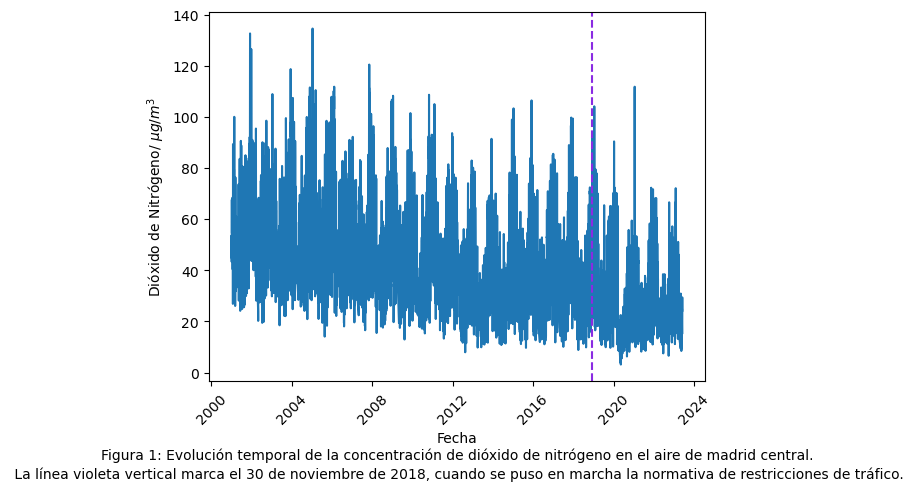

In [121]:
sns.lineplot(x='fecha', y='media_diaria', data = media_estaciones)

# Definimos los ejes
plt.xlabel('Fecha')
ylabel = 'Dióxido de Nitrógeno/ ' + r'$\mu g/m^3$'
plt.ylabel(ylabel)

# Guardamos el inicio de la normativa y lo convertimos en datetime
normativa = '2018-11-30'

highlight_date = pd.to_datetime(normativa)

# Anadimos una raya vertical violeta en la fecha de la normativa
plt.axvline(x=highlight_date, color='blueviolet', linestyle='--')  

plt.text(0.5, -0.2, 'Figura 1: Evolución temporal de la concentración de dióxido de nitrógeno en el aire de madrid central.',
         ha='center', va='center', transform=plt.gca().transAxes)
plt.text(0.5, -0.25,' La línea violeta vertical marca el 30 de noviembre de 2018, cuando se puso en marcha la normativa' 
         ' de restricciones de tráfico.', ha='center', va='center', transform=plt.gca().transAxes)


plt.xticks(rotation=45)

plt.show()

Para analizar mejor los resultados, representa también **cómo varia la emisión media diaria de este gas frente al año anterior** a lo largo del tiempo.

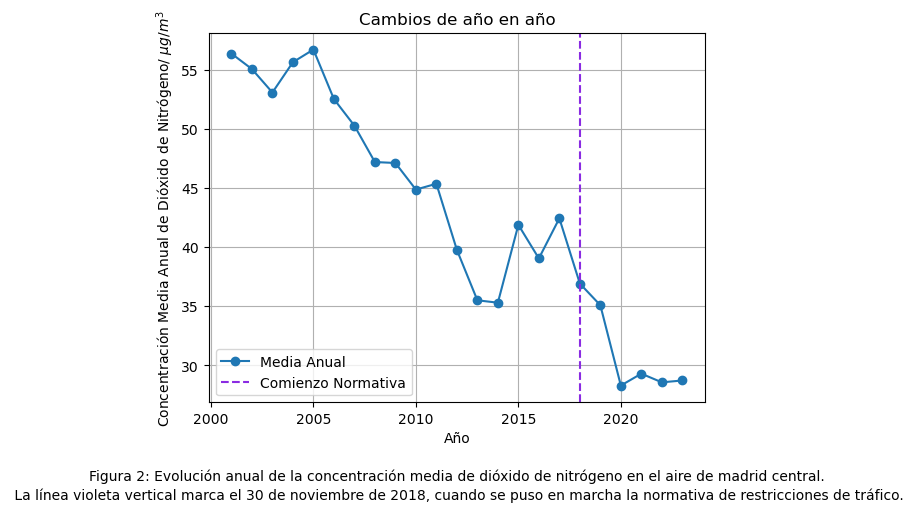

In [122]:
#  Extraemos el año de la columna `fecha`
NO2_df['Year'] = NO2_df['fecha'].dt.year

# Tomamos la media por año
media_anual = NO2_df.groupby('Year')['media_diaria'].mean()


# Para poder representar tanto la media anual como una línea vertical marcando 
# el inicio de la normativa, vamos a crear subgráficas 
fig, ax1 = plt.subplots()

ax1.plot(media_anual.index, media_anual.values, marker='o', label='Media Anual')
ax1.set_xlabel('Año')
ax1.set_ylabel('Concentración Media Anual de ' + ylabel )
ax1.set_title('Cambios de año en año')
ax1.grid(True)

#  Añadimos una línea vertical roja de guiones para la fecha 30/11/2018
ax1.axvline(pd.to_datetime('2018-11-30').year, color='blueviolet', linestyle='--', label='Comienzo Normativa')
ax1.legend()

# Leyendas
plt.text(0.5, -0.2, 'Figura 2: Evolución anual de la concentración media de dióxido de nitrógeno en el aire de madrid central.',
         ha='center', va='center', transform=plt.gca().transAxes)
plt.text(0.5, -0.25,' La línea violeta vertical marca el 30 de noviembre de 2018, cuando se puso en marcha la normativa' 
         ' de restricciones de tráfico.', ha='center', va='center', transform=plt.gca().transAxes)


plt.show()


**¿Qué conclusiones sacas tras este primer análisis?** 
* ¿Realmente ha disminuido la concentración del NO2 tras la aplicación de Madrid Central? 
* ¿Utilizarías algún otro gráfico para mostrar los resultados? En caso afirmativo, muéstralo.

###### Conclusiones del Primer Análisis
* En efecto, la cantidad media de dióxido de nitrógeno está en decremento desde el año dos mil. 
* Actualmente se encuentra en los valores mínimos reportados desde el comienzo del milenio. 

* La media anual nos ayuda bastante más que la cantidad neta de dióxido de nitrógeno para poder evaluar el efecto de la entrada en vigor de la normativa de restricción del tráfico a finales del 2018. 
* En la Figura 1, donde hemos representado el resultado de la medición de dióxido de nitrógeno a través del tiempo, se puede observar que aparenta un pequeño descenso de la cantidad media de dióxido de nitrógeno.
* Sin embargo, esto se confirma de forma más concluyente con la gráfica de la Figura 2, en la cual se puede ver un descenso a lo largo del tiempo de la cantidad media anual de dióxido de nitrógeno.

* Algo interesante que se puede mencionar en este punto es que, según la Figura 2, la cantidad de dióxido de nitrógeno media está en descenso desde el año 2000, incluso **antes** de entrar en vigor la normativa de restricción del tráfico del 2018.
* Parte de este decremento se puede adjudicar a la implementación de una serie de estándares de emisión llamados los estándares EURO que implementó la Unión Europea.

* Estos estándares se han estado implementando en iteraciones, cada una más estricta que la anterior. El estándar [EURO 4](https://www.europarl.europa.eu/registre/docs_autres_institutions/commission_europeenne/sec/2005/1745/COM_SEC(2005)1745_EN.pdf), puesto en marcha en el 2005, redujo de manera significativa las emisiones de dióxido de óxidos de nitrógeno permitidas por los vehículos diesel comparados con el estándar anterior europeo.

* En la Figura 2 se puede observar claramente que es en esta fecha en 2005 cuando la mayor caída de concentración empieza a ocurrir.

* Además, en el 2008, la Unión Europea implementó la directiva de la calidad del aire [Cleaner Air for Europe](https://eur-lex.europa.eu/EN/legal-content/summary/cleaner-air-for-europe.html) que restringía de forma legal los límites para los mayores contaminantes del aire, incluyendo el dióxido de nitrógeno.

* Como esta era una normativa legal, todos los países miembros de la Unión Europea incluyendo España tuvieron que adherirse.
En la Figura 2 podemos ver como en el 2008 se continúa un descenso en la cantidad de dióxido de nitrógeno en el aire, lo cual evidencia la efectividad de estas políticas.

* Hay otros factores que suman en el esfuerzo contra los contaminantes en el aire.

* Por ejemplo, desde el 2014,  el uso de los coches diésel fue disminuyendo en España, según reporta [El Periódico](https://www.elperiodico.com/es/economia/20160506/ventas-coches-diesel-gasoleo-gasolina-electricos-hibridos-5112843).

![Gráfica de porcentaje de cuota de mercado de los vehículos diésel en España desde el 1990 hasta el 2015 en la cual se puede observar que la cantidad de vehículos diésel disminuye desde el 2014.](images/diesel_esp.jpg)

* Además, la transición a nuevas formas de energía más limpias también ha ayudado a reducir el porcentaje de combustibles derivados del petróleo en uso. Según el blog del canal Economia3, únicamente la energía eólica ha incrementado en un 10%, desde el 2004.

![Gráfica de porcentaje de De producción de energía eólica desde el 2004 hasta hoy en la que se puede ver un incremento anual de año a año.](images/renovables.jpg)



Con respecto al resto de gases que comentábamos al inicio: CO, NO y NOx, **¿ha habido un descenso a nivel anual en la emisión media de los gases entre los años 2018 y 2021?**

In [123]:
final['MAGNITUD'].value_counts()

8     135127
12    135101
7     135096
6      59876
Name: MAGNITUD, dtype: int64

In [124]:
# Creamos el nuevo df con las cuatro magnitudes a parte de NO2: CO, NO y NOx 
# y la media tomada en todas las estaciones acada dia.

final_media_estaciones = final.groupby(['fecha', 'MAGNITUD'])['media_diaria'].mean().reset_index()
final_media_estaciones

,fecha,MAGNITUD,media_diaria
0,2001-01-01,6,0.953125
1,2001-01-01,7,47.513889
2,2001-01-01,8,46.753472
3,2001-01-01,12,119.559028
4,2001-01-02,6,0.725000
...,...,...,...
29881,2023-05-30,12,35.779762
29882,2023-05-31,6,0.295833
29883,2023-05-31,7,5.841667
29884,2023-05-31,8,24.177083


Por referencia, recordamos la leyenda de la columna **MAGNITUD**:
* NO2 <=> `08`
* CO <=> `06`
* NO <=> `07`
* NOx <=> `12`

In [125]:
# Reemplazamos esos valores numericos por el nombre de cada molecula:
final_media_estaciones['MAGNITUD'] = final_media_estaciones['MAGNITUD'].replace({
    8: 'Dióxido de Nitrógeno (NO2)',
    6: 'Monóxido de Carbono (CO)',
    7: 'Monóxido de Nitrógeno (NO)',
    12: 'Óxidos de Nitrógeno (NOx)'})

In [126]:
final_media_estaciones

,fecha,MAGNITUD,media_diaria
0,2001-01-01,Monóxido de Carbono (CO),0.953125
1,2001-01-01,Monóxido de Nitrógeno (NO),47.513889
2,2001-01-01,Dióxido de Nitrógeno (NO2),46.753472
3,2001-01-01,Óxidos de Nitrógeno (NOx),119.559028
4,2001-01-02,Monóxido de Carbono (CO),0.725000
...,...,...,...
29881,2023-05-30,Óxidos de Nitrógeno (NOx),35.779762
29882,2023-05-31,Monóxido de Carbono (CO),0.295833
29883,2023-05-31,Monóxido de Nitrógeno (NO),5.841667
29884,2023-05-31,Dióxido de Nitrógeno (NO2),24.177083


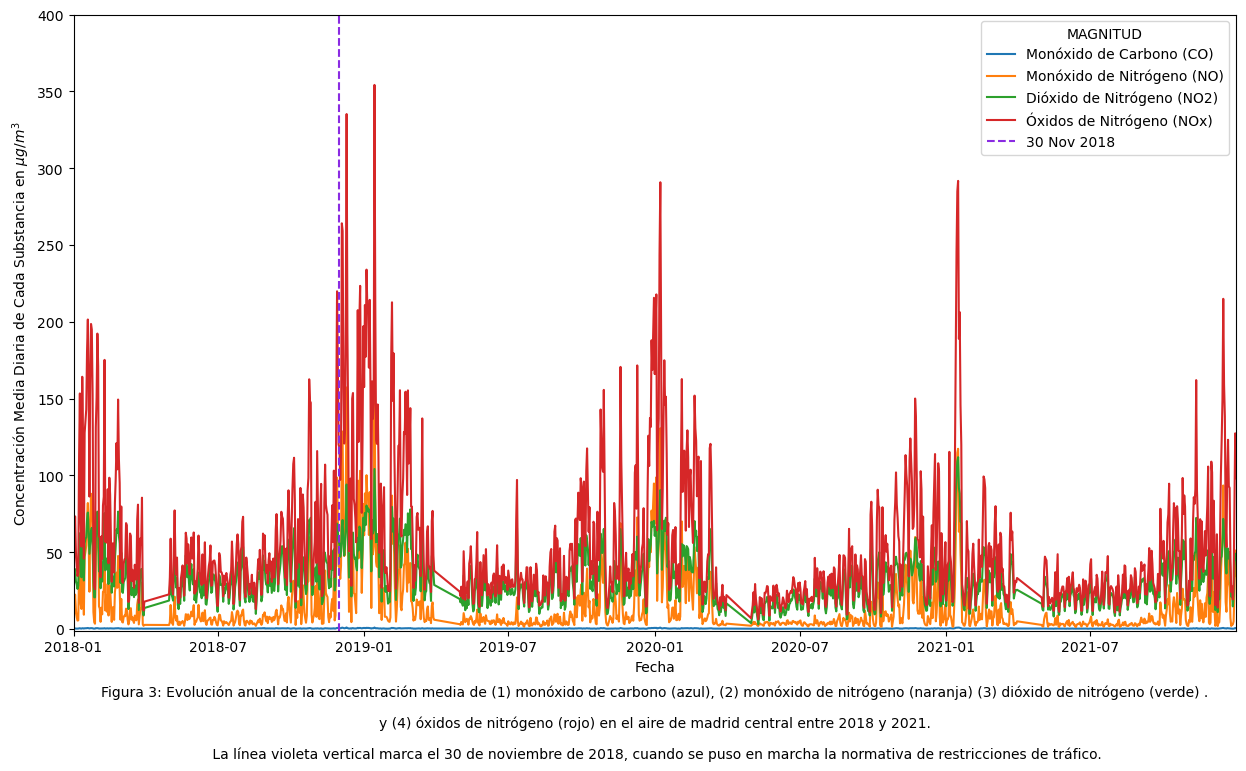

In [127]:
plt.figure(figsize=(15, 8))
plot = sns.lineplot(x='fecha', y='media_diaria', hue='MAGNITUD', data=final_media_estaciones)

# Añadimos una raya vertical para marcar el comienzo de la puesta en vigencia de la normativa
plt.axvline(pd.to_datetime('2018-11-30'), color='blueviolet', linestyle='--')

plt.xlabel('Fecha')
plt.ylabel('Concentración Media Diaria de Cada Substancia en ' r'$\mu g/m^3$')

# Creamos una instancia line2D para la leyenda
violet_line = mlines.Line2D([], [], color='blueviolet', linestyle='--', markersize=15, label='30 Nov 2018')

# Obtenemos las handles y etiquetas 
handles, labels = plot.get_legend_handles_labels()

# Añadimos una línea vertical a las handles y añadimos su etiqueta a las demás
handles.append(violet_line)
labels.append('30 Nov 2018')

# Set the new legend
plt.legend(handles=handles, labels=labels, title='MAGNITUD', loc='best')

# Leyenda de Imagen
plt.text(0.5, -0.1, 'Figura 3: Evolución anual de la concentración media de (1) monóxido de carbono (azul), (2) monóxido de nitrógeno (naranja) (3) dióxido de nitrógeno (verde) .',
         ha='center', va='center', transform=plt.gca().transAxes)
plt.text(0.5, -0.15, 'y (4) óxidos de nitrógeno (rojo) en el aire de madrid central entre 2018 y 2021.',
         ha='center', va='center', transform=plt.gca().transAxes)
plt.text(0.5, -0.2,' La línea violeta vertical marca el 30 de noviembre de 2018, cuando se puso en marcha la normativa' 
         ' de restricciones de tráfico.', ha='center', va='center', transform=plt.gca().transAxes)

# Rango de tiempo
plt.xlim([pd.to_datetime('2018-01-01'), pd.to_datetime('2021-12-31')])

# Escala vertical
plt.ylim(-1, 400)

plt.show()


Las fluctuaciones por mes del año de los óxidos de nitrógeno oscurecen las demás. Los datos de monóxido de carbono no están normalizados y, por lo tanto, en la misma gráfica que los demás, muestran un cambio imperceptible.

Para llevar a cabo la normalización de las cuatro substancias vamos a aplicar la normalización tipo *Z-score* para cada magnitud de forma separada. Este método transforma los datos para que tengan una media de 0 y una desviación estándar de 1,  facilitando así poder comparar tendencias que ocurren en diferentes escalas.

In [128]:
from scipy.stats import zscore

# Aplicamos Normalización z-score a cada MAGNITUD
final_media_estaciones['z-score'] = final_media_estaciones.groupby('MAGNITUD')['media_diaria'].transform(zscore)
final_media_estaciones

,fecha,MAGNITUD,media_diaria,z-score
0,2001-01-01,Monóxido de Carbono (CO),0.953125,2.046122
1,2001-01-01,Monóxido de Nitrógeno (NO),47.513889,0.502313
2,2001-01-01,Dióxido de Nitrógeno (NO2),46.753472,0.177062
3,2001-01-01,Óxidos de Nitrógeno (NOx),119.559028,0.432525
4,2001-01-02,Monóxido de Carbono (CO),0.725000,1.144090
...,...,...,...,...
29881,2023-05-30,Óxidos de Nitrógeno (NOx),35.779762,-0.724042
29882,2023-05-31,Monóxido de Carbono (CO),0.295833,-0.552884
29883,2023-05-31,Monóxido de Nitrógeno (NO),5.841667,-0.645389
29884,2023-05-31,Dióxido de Nitrógeno (NO2),24.177083,-0.990054


Para evitar la superposición de las gráficas y facilitar la resolución de detalles, vamos a aplicar un método de remuestreo, creando un nuevo dataframe llamado `remuestreado`. **Así representaremos únicamente un dato mensual.**

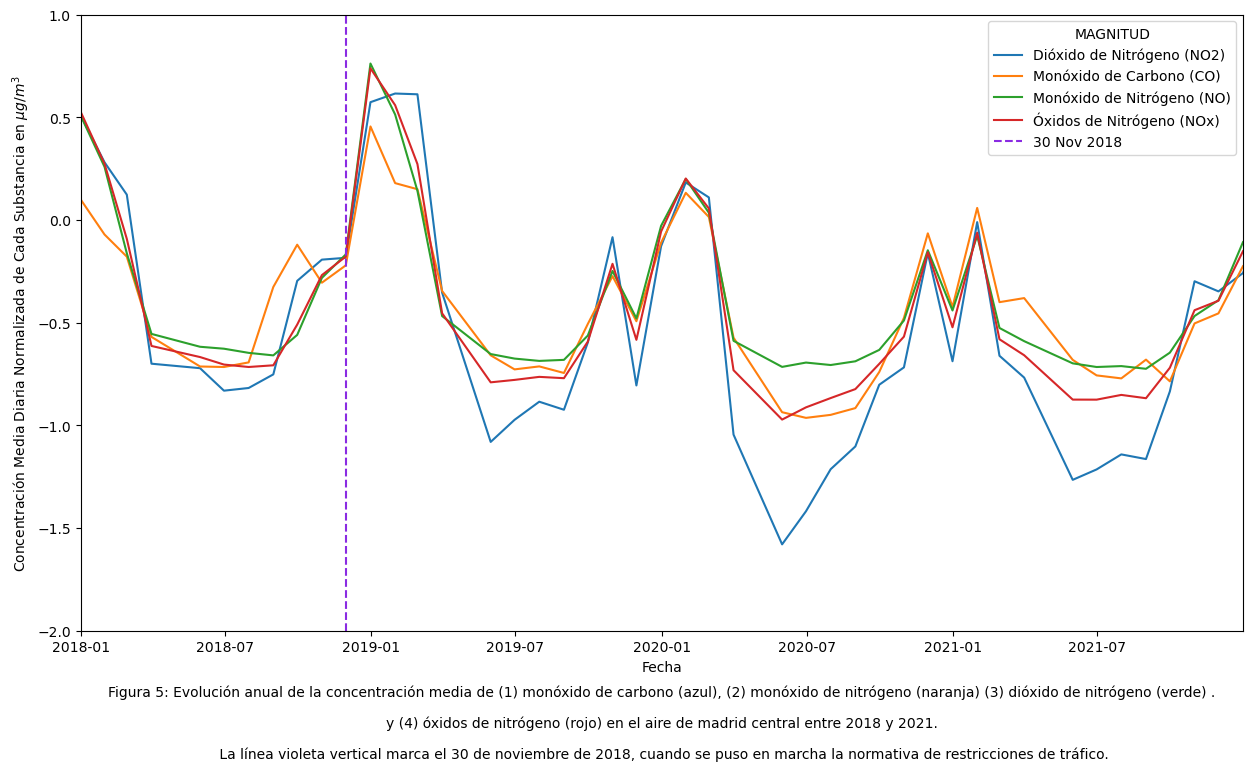

In [129]:
# Remuestreo:
remuestreado = final_media_estaciones.set_index('fecha').groupby('MAGNITUD').resample('M').mean().reset_index()

# Creamos gráfica
plt.figure(figsize=(15, 8))
plot = sns.lineplot(x='fecha', y='z-score', hue='MAGNITUD', data=remuestreado)

# for i in range(len(plot.lines)):
#     plot.lines[i].set_linestyle("--")
    
# Añadimos una línea vertical 
plt.axvline(pd.to_datetime('2018-11-30'), color='blueviolet', linestyle='--')

plt.xlabel('Fecha')
plt.ylabel('Concentración Media Diaria Normalizada de Cada Substancia en ' r'$\mu g/m^3$')

# Creamos una instancia Line2D instance para la leyenda 
violet_line = mlines.Line2D([], [], color='blueviolet', linestyle='--', markersize=15, label='30 Nov 2018')

# Obtenemos las handles y etiquetas 
handles, labels = plot.get_legend_handles_labels()

# Añadimos una línea vertical a las handles y añadimos su etiqueta a las demás
handles.append(violet_line)
labels.append('30 Nov 2018')

# Leyenda de Imagen
plt.legend(handles=handles, labels=labels, title='MAGNITUD', loc='best')

plt.text(0.5, -0.1, 'Figura 5: Evolución anual de la concentración media de (1) monóxido de carbono (azul), (2) monóxido de nitrógeno (naranja) (3) dióxido de nitrógeno (verde) .',
         ha='center', va='center', transform=plt.gca().transAxes)
plt.text(0.5, -0.15, 'y (4) óxidos de nitrógeno (rojo) en el aire de madrid central entre 2018 y 2021.',
         ha='center', va='center', transform=plt.gca().transAxes)
plt.text(0.5, -0.2,' La línea violeta vertical marca el 30 de noviembre de 2018, cuando se puso en marcha la normativa' 
         ' de restricciones de tráfico.', ha='center', va='center', transform=plt.gca().transAxes)

# Rango de tiempo
plt.xlim([pd.to_datetime('2018-01-01'), pd.to_datetime('2021-12-31')])
plt.ylim(-2, 1)

plt.show()


Una vez normalizados los datos, podemos ver que la amplitud de las oscilaciones anuales parece disminuir de año en año. Sin embargo, estas oscilaciones dificultan la precisión de este descenso, si existe.

Me pregunto si cogiendo la media anual - igual que hicimos en la Figura 2 - nos ayudaría a ver estas tendencias. 

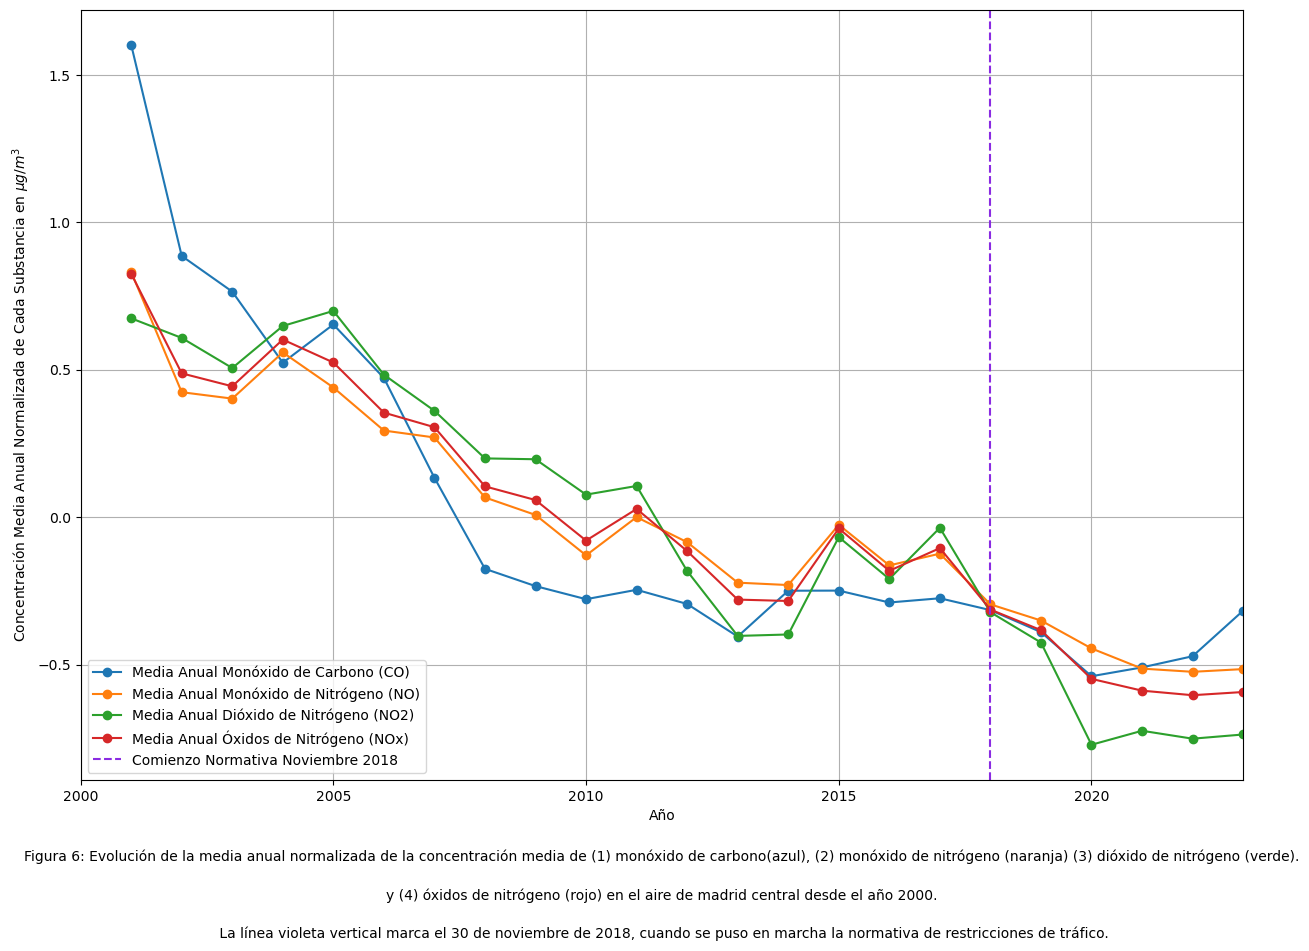

In [130]:
# Creamos gráfica
fig, ax1 = plt.subplots(figsize=(15, 10))

# Hacemos un bucle sobre los valores únicos de la columna MAGNITUD
for magnitud in final_media_estaciones['MAGNITUD'].unique():

    # Creamos un dataframe del subconjunto de filas que tienen la magnitud actual 
    subset = final_media_estaciones[final_media_estaciones['MAGNITUD'] == magnitud].copy()
    
    # Calculamos una media anual para el subconjunto
    subset['fecha'] = pd.to_datetime(subset['fecha'])
    media_anual = subset.resample('Y', on='fecha')['z-score'].mean()

    # Graficamos la línea de dispersión para el subconjunto 
    ax1.plot(media_anual.index.year, media_anual.values, marker='o', label=f'Media Anual {magnitud}')

# Establecemos las etiquetas y el título
ax1.set_xlabel('Año')
ax1.set_ylabel('Concentración Media Anual Normalizada de Cada Substancia en ' r'$\mu g/m^3$')

ax1.grid(True)

# Añadimos la línea vertical que marca el comienzo de la normativa
ax1.axvline(pd.to_datetime('2018-11-30').year, color='blueviolet', linestyle='--', label='Comienzo Normativa Noviembre 2018')
ax1.legend()

# Leyenda de Imagen
plt.text(0.5, -0.1, 'Figura 6: Evolución de la media anual normalizada de la concentración media de (1) monóxido de carbono'
         '(azul), (2) monóxido de nitrógeno (naranja) (3) dióxido de nitrógeno (verde).',
         ha='center', va='center', transform=plt.gca().transAxes)
plt.text(0.5, -0.15, 'y (4) óxidos de nitrógeno (rojo) en el aire de madrid central desde el año 2000.',
         ha='center', va='center', transform=plt.gca().transAxes)
plt.text(0.5, -0.2,' La línea violeta vertical marca el 30 de noviembre de 2018, cuando se puso en marcha la normativa' 
         ' de restricciones de tráfico.', ha='center', va='center', transform=plt.gca().transAxes)

# Rango de tiempo
plt.xlim([2000, 2023])

plt.show()


Restringiendo esta gráfica entre el 2018 y 2021:

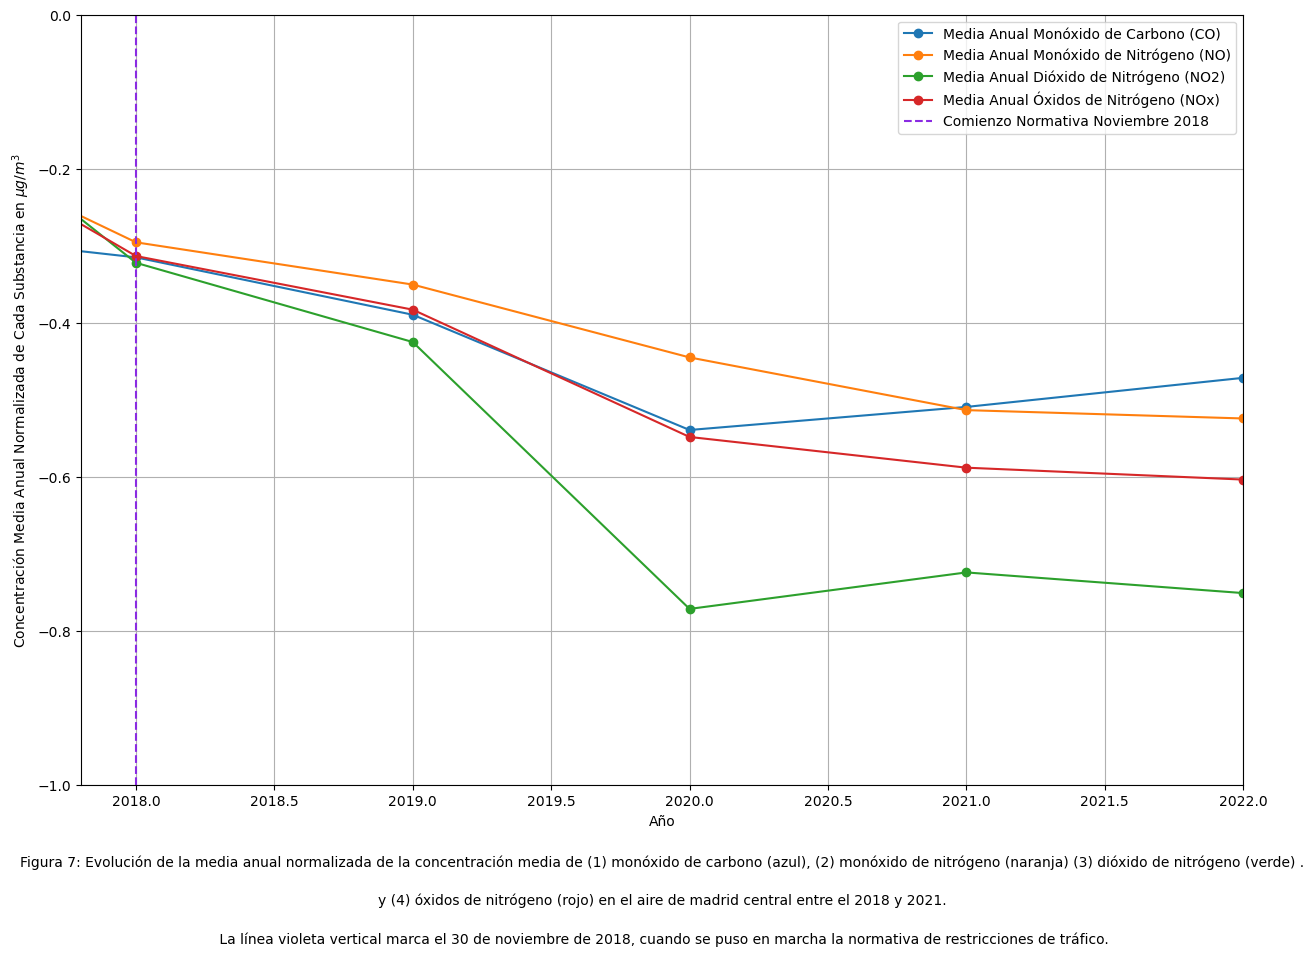

In [131]:
# Creamos gráfica
fig, ax1 = plt.subplots(figsize=(15, 10))

# Hacemos un bucle sobre los valores únicos de la columna MAGNITUD
for magnitud in final_media_estaciones['MAGNITUD'].unique():

    # Creamos un dataframe del subconjunto de filas que tienen la magnitud actual 
    subset = final_media_estaciones[final_media_estaciones['MAGNITUD'] == magnitud].copy()
    
    # Calculamos una media anual para el subconjunto
    subset['fecha'] = pd.to_datetime(subset['fecha'])
    media_anual = subset.resample('Y', on='fecha')['z-score'].mean()

    # Graficamos la línea de dispersión para el subconjunto 
    ax1.plot(media_anual.index.year, media_anual.values, marker='o', label=f'Media Anual {magnitud}')

# Establecemos las etiquetas y el título
ax1.set_xlabel('Año')
ax1.set_ylabel('Concentración Media Anual Normalizada de Cada Substancia en ' r'$\mu g/m^3$')

ax1.grid(True)

# Añadimos la línea vertical que marca el comienzo de la normativa
ax1.axvline(pd.to_datetime('2018-11-30').year, color='blueviolet', linestyle='--', label='Comienzo Normativa Noviembre 2018')
ax1.legend()

# Leyenda de Imagen
plt.text(0.5, -0.1, 'Figura 7: Evolución de la media anual normalizada de la concentración media de (1) monóxido de carbono (azul), (2) monóxido de nitrógeno (naranja) (3) dióxido de nitrógeno (verde) .',
         ha='center', va='center', transform=plt.gca().transAxes)
plt.text(0.5, -0.15, 'y (4) óxidos de nitrógeno (rojo) en el aire de madrid central entre el 2018 y 2021.',
         ha='center', va='center', transform=plt.gca().transAxes)
plt.text(0.5, -0.2,' La línea violeta vertical marca el 30 de noviembre de 2018, cuando se puso en marcha la normativa' 
         ' de restricciones de tráfico.', ha='center', va='center', transform=plt.gca().transAxes)

# Rango de tiempo
plt.xlim([2017.8, 2022]) #Empezamos con un decimal porque, si no, la linea vertical se aproxima a 2019.

# Escala vertical
plt.ylim(-1, 0)

plt.show()


##### Conclusiones
* Efectivamente, habiendo tomado la media anual de cada sustancia a través del tiempo se revela la disminución de concentración desde el año 2000 hasta el presente. 
* Esta progresión ocurre de manera gradual.
* Se puede observar que, después del 2005, cuando la primera iniciativa europea de control de partículas de calidad del aire fue implementada, como hemos detallado en el ejercicio anterior, las cantidades bajaron precipitadamente. 
* Es difícil atribuir la disminución en las concentraciones medias a la implementación de la normativa de restricción de tráfico en Madrid central en 2018, ya que la disminución posterior a este punto en el tiempo está en sincronía con la trayectoria anterior a la normativa.
* Una nota que debemos especificar en este punto es que los datos validados de monóxido de carbono eran menos de la mitad del equivalente en las demás sustancias (ver output de celda 42). este hecho coma no solo revela la necesidad de mejorar tanto la Adquisición De medidas como la validación de esta sustancia,  sino que también indica que la verosimilitud de esta curva de datos (azul) en la Figura 6 puede ser menor que la de las otras sustancias. 
* Finalmente, queremos dejar saber al lector que nota un incremento en la concentración de todas las sustancias en el 2023 en la Figura 7,  que hoy, a Julio de  ese mismo año,  la media ha sido tomada sobre los datos existentes; es decir, de enero a mayo. Por lo tanto, la bajada de verano no ha sucedido, y el valor medio “anual” representado es artificialmente alto.

### Estudio del efecto de las precipitaciones sobre las emisiones de estos gases


Esta variación puede deberse a un aumento/disminución de las precipitaciones en esos años. Por lo que, sería interesante analizar el efecto de las precipitaciones, para ello disponemos de las precipitaciones a lo largo de los años 2018 y 2019 en Madrid, en el fichero `historico.clima.xlsx`.

**¿Explica el comportamiento anual de las precipicationes la variación en los niveles de gases bajo estudio o podemos atribuir dicho efecto a la implementación de Madrid central?**

In [132]:
precipitaciones = pd.read_excel('historico-clima.xlsx', parse_dates = True);

In [133]:
precipitaciones

,timestamp,Madrid Precipitation Total
0,2007-01-01,0.0
1,2007-01-02,0.0
2,2007-01-03,0.0
3,2007-01-04,0.0
4,2007-01-05,0.0
...,...,...
4743,2019-12-27,0.0
4744,2019-12-28,0.0
4745,2019-12-29,0.0
4746,2019-12-30,0.0


La tabla ha sido correctamente leida con una columna con objetos `datetime`.

In [134]:
precipitaciones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4748 entries, 0 to 4747
Data columns (total 2 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   timestamp                   4748 non-null   datetime64[ns]
 1   Madrid Precipitation Total  4748 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 74.3 KB


In [135]:
final_con_precipitaciones = final_media_estaciones.merge(precipitaciones, left_on='fecha', right_on='timestamp', how='inner')
final_con_precipitaciones = final_con_precipitaciones.drop('timestamp', axis = 1)
final_con_precipitaciones['Precipitation z-score'] = zscore(final_con_precipitaciones['Madrid Precipitation Total'])
final_con_precipitaciones

,fecha,MAGNITUD,media_diaria,z-score,Madrid Precipitation Total,Precipitation z-score
0,2007-01-01,Monóxido de Carbono (CO),0.571429,0.536851,0.0,-0.256525
1,2007-01-01,Monóxido de Nitrógeno (NO),31.886364,0.071913,0.0,-0.256525
2,2007-01-01,Dióxido de Nitrógeno (NO2),42.185606,-0.059080,0.0,-0.256525
3,2007-01-01,Óxidos de Nitrógeno (NOx),91.140152,0.040205,0.0,-0.256525
4,2007-01-02,Monóxido de Carbono (CO),0.805952,1.464185,0.0,-0.256525
...,...,...,...,...,...,...
17375,2019-12-30,Óxidos de Nitrógeno (NOx),193.135417,1.448242,0.0,-0.256525
17376,2019-12-31,Monóxido de Carbono (CO),0.728571,1.158212,0.0,-0.256525
17377,2019-12-31,Monóxido de Nitrógeno (NO),94.729167,1.802677,0.0,-0.256525
17378,2019-12-31,Dióxido de Nitrógeno (NO2),70.406250,1.399823,0.0,-0.256525


Vamos a crear otra gráfica:

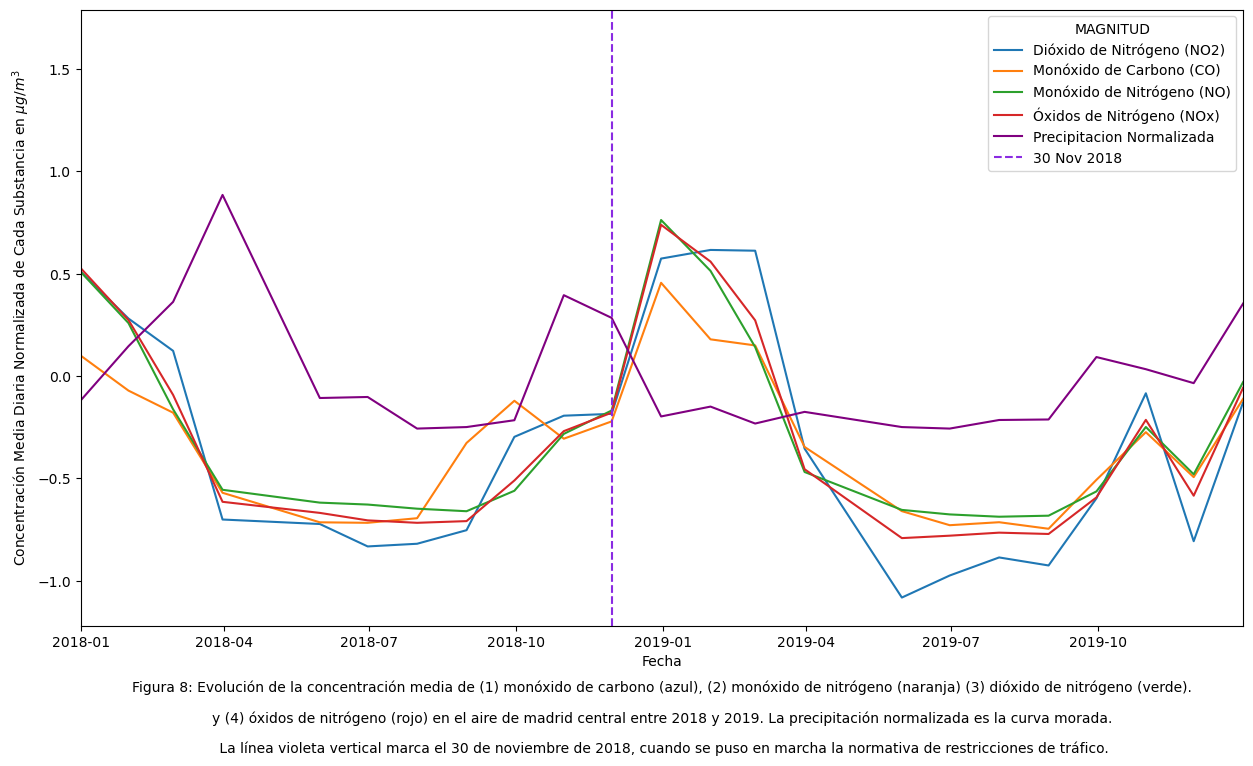

In [136]:
# Remuestreo:
remuestreado = final_con_precipitaciones.set_index('fecha').groupby('MAGNITUD').resample('M').mean().reset_index()

# Tambien remuestreamos los datos de Precipitation para agilzar el proceso:
precipitation_remuestreado = final_con_precipitaciones.set_index('fecha').resample('M')['Precipitation z-score'].mean().reset_index()

# Creamos gráfica
plt.figure(figsize=(15, 8))
plot = sns.lineplot(x='fecha', y='z-score', hue='MAGNITUD', data=remuestreado)

# Add precipitation data to the same plot
sns.lineplot(x='fecha', y='Precipitation z-score', data=precipitation_remuestreado, color='purple', label='Precipitacion Normalizada')

# Añadimos una línea vertical 
plt.axvline(pd.to_datetime('2018-11-30'), color='blueviolet', linestyle='--')

plt.xlabel('Fecha')
plt.ylabel('Concentración Media Diaria Normalizada de Cada Substancia en '+ r'$\mu g/m^3$')

# Creamos una instancia Line2D instance para la leyenda 
violet_line = mlines.Line2D([], [], color='blueviolet', linestyle='--', markersize=15, label='30 Nov 2018')

# Obtenemos las handles y etiquetas 
handles, labels = plot.get_legend_handles_labels()

# Añadimos una línea vertical a las handles y añadimos su etiqueta a las demás
handles.append(violet_line)
labels.append('30 Nov 2018')

# Leyenda de Imagen
plt.legend(handles=handles, labels=labels, title='MAGNITUD', loc='best')

plt.text(0.5, -0.1, 'Figura 8: Evolución de la concentración media de (1) monóxido de carbono'
         ' (azul), (2) monóxido de nitrógeno (naranja) (3) dióxido de nitrógeno (verde).',
         ha='center', va='center', transform=plt.gca().transAxes)
plt.text(0.5, -0.15, 'y (4) óxidos de nitrógeno (rojo) en el aire de madrid central entre 2018 y 2019. La precipitación normalizada es la curva morada.',
         ha='center', va='center', transform=plt.gca().transAxes)
plt.text(0.5, -0.2,' La línea violeta vertical marca el 30 de noviembre de 2018, cuando se puso en marcha la normativa' 
         ' de restricciones de tráfico.', ha='center', va='center', transform=plt.gca().transAxes)

# Rango de tiempo
plt.xlim([pd.to_datetime('2018-01-01'), pd.to_datetime('2019-12-31')])

plt.show()

* En abril del año 2018, se puede observar un incremento de las precipitaciones en la Figura 8, tras el cual las concentraciones normalizadas de todas las sustancias disminuyen en picado aceleradamente. 
* Sin embargo , en noviembre del 2018, se vuelve a observar un “valle” en las gráficas de las concentraciones de la sustancias mientras hay un aumento de las precipitaciones. 
* Después de esta fecha, se observa una disminución de la concentración normalizada de todas las sustancias en el aire. No obstante, esta es la etapa posterior a la entrada en vigencia de la normativa de calidad del aire en Madrid central, así que es complicado relacionar esta disminución con la presencia o falta de altas precipitaciones.

### Modelado de los datos

¿Qué usos de Machine Learning verías aplicables a este conjunto de datos?

* Si hubiera más datos de precipitación disponibles, que abarcaran un rango temporal más amplio, sería interesante utilizar una regresión linear para calcular la concentración media de las cuatro substancias basado en los cambios en la precipitación total. 
* Dado que las concentraciones de cada una de las cuatro substancias existen en escalas bastante distintas, podemos pensar en dos soluciones diferentes:

    * Entrenar a un único modelo, y hacer que la target variable sea el Z-score medio de las concentraciones de las cuatro substancias. Este modelo no tendría un poder cuantitativo, pero sería útil como una guía visual en el tiempo. 
    * La otra solución sería crear cuatro modelos distintos entrenados en datos de cada una de las cuatro sustancias que tenemos en nuestra base de datos. Este modelo tendría un poder cuantitativo, ya que no tendríamos que normalizar los datos a priori. 

* Deberíamos también concentrarnos únicamente en la en una de las dos: o la etapa anterior a la entrada en vigencia de la normativa, o la etapa posterior a ella. No deberíamos crear un modelo que mezclara datos de las dos, ya que no son comparables debido a factores externos.
* Con vistas a cuál de los dos rangos de datos serían más interesantes para generar un modelo que pueda tener una aplicación útil para un usuario, deberíamos enfocarnos en los datos de precipitación posteriores a la entrada en vigencia a la normativa, ya que ellos nos permitirían predecir la concentración en el aire en el futuro basados en la situación actual


¿Podrías usar uno de esos modelos de Machine Learning para **predecir las emisiones de NO2 durante la siguiente semana** al fin de los datos de tu dataset (agregado a nivel día)?

Dada esta tarea, vamos a utilizar los datos tanto de precipitación como de dióxido de nitrógeno después de la entrada en vigor de la normativa de calidad del aire en Madrid central. Así, generaremos una nueva tabla, llamada `precip_no2`.

In [137]:
# Aislamos los valores de dióxido de nitrógeno de la tabla final
mascara = final_con_precipitaciones['MAGNITUD'] == 'Dióxido de Nitrógeno (NO2)'
precip_no2 = final_con_precipitaciones[mascara]

# Eliminamos las columnas que ya no traen ningún valor 
precip_no2 = precip_no2.drop(['MAGNITUD', 'z-score', 'Precipitation z-score'], axis = 1)

# Restringimos los datos en el tiempo a la etapa posterior a la entrada en 
# vigor de la normativa
normativa = datetime.strptime('2018-11-30', '%Y-%m-%d')
datemask = precip_no2['fecha'] >= normativa
precip_no2 = precip_no2[datemask]
precip_no2

,fecha,media_diaria,Madrid Precipitation Total
15918,2018-11-30,57.557292,0.4
15922,2018-12-01,55.062500,0.0
15926,2018-12-02,46.979167,0.0
15930,2018-12-03,50.158333,0.0
15934,2018-12-04,66.703125,0.0
...,...,...,...
17362,2019-12-27,54.868056,0.0
17366,2019-12-28,69.809028,0.0
17370,2019-12-29,66.668561,0.0
17374,2019-12-30,67.890625,0.0


Como tenemos datos de carácter temporal, no tiene sentido hacer `train/test/split`.
En vez de ello, vamos a separar los datos manualmente. Dentro del rango para el cual tenemos datos de las precipitaciones, voy a separar el primer 70% para entrenar al modelo. 

In [138]:
final_datos = datetime.strptime('2019-12-31', '%Y-%m-%d')
rango = final_datos - normativa
final_training = normativa + 0.7*rango
print('La fecha que marca el final de los datos para entrenar al modelo es el', 
      final_training.strftime('%d/%m/%Y'))

La fecha que marca el final de los datos para entrenar al modelo es el 03/09/2019


Dividiremos `precip_no2` en dos: `training_70`, que llegará hasta el 3 de septiembre del 2019; y `test_30`, que abarcará el resto del año 2019

In [139]:
# Definimos training
datetime_mask_70 = precip_no2['fecha'] <= final_training
training_70 = precip_no2[datetime_mask_70]
# Definimos testing
test_30 = precip_no2[~datetime_mask_70]

In [140]:
from sklearn.linear_model import LinearRegression
import numpy as np

def linear_train_and_predict(train, test):
    X_train = np.array(train['Madrid Precipitation Total']).reshape(-1,1)
    y_train = np.log(train['media_diaria'])
    X_test = np.array(test['Madrid Precipitation Total']).reshape(-1,1)
    
    # Entrenamos al modelo 
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    
    # Predecimos 
    y_pred = lr.predict(X_test)
    
    return np.exp(y_pred) # return to original scale


Definimos una ventana rodante para simular la creación de un pronóstico dinámico. En nuestro caso la ventana es la tabla compuesta por los datos que están disponibles para entrenar al modelo en el momento de cada predicción. Según el tiempo avanza, la ventana se desplaza también, y continuamente estamos re-entrenando nuestro modelo con los datos más recientes para llevar a cabo predicciones sobre el periodo siguiente. 

In [141]:
ventana_size = 30
predicciones = []
cutoff = int(len(precip_no2) * 0.7)

for i in range(ventana_size, len(test_30)):
    train_temp = pd.concat([training_70, test_30.iloc[:i]])  # use pandas.concat instead of append
    test_temp = test_30.iloc[i:i+1]  # test data is a single sample from test_30
    predicciones.append(linear_train_and_predict(train_temp, test_temp))


# Creamos la lista de predicciones
predicciones = [item for sublist in predicciones for item in sublist]
# predicciones

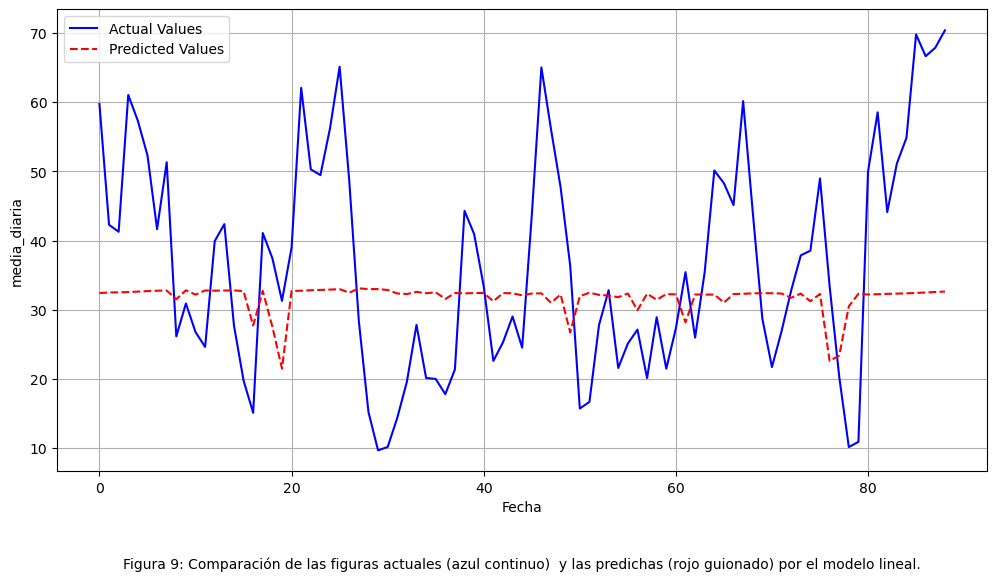

In [142]:
import matplotlib.pyplot as plt

# Convert test_30 and predicciones to numpy arrays for easier plot handling
test_30_values = test_30['media_diaria'].to_numpy()
predicciones_values = np.array(predicciones)

# Trim test_30_values to match the length of predicciones_values
test_30_values_trimmed = test_30_values[-len(predicciones_values):]

# Generate index for x-axis
index = range(0, len(test_30_values_trimmed))

# Plot actual values
plt.figure(figsize=(12, 6))
plt.plot(index, test_30_values_trimmed, color='blue', label='Actual Values')

# Plot predicted values
plt.plot(index, predicciones_values, color='red', linestyle='dashed', label='Predicted Values')


plt.xlabel('Fecha')
plt.ylabel('media_diaria')
plt.legend()
plt.grid(True)


plt.text(0.5, -0.2, 'Figura 9: Comparación de las figuras actuales (azul continuo)  y las predichas (rojo guionado) por el modelo lineal.',
         ha='center', va='center', transform=plt.gca().transAxes)

plt.show()


**Se puede observar que la predicción del modelo no continúa el mismo patrón que los datos reales.**

Ahora podemos evaluar el rendimiento del modelo:

In [143]:
from sklearn.metrics import mean_squared_error, r2_score

y_test = np.array(test_30['media_diaria'][ventana_size:])
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, predicciones)))
print("Test R2 Score: ", r2_score(y_test, predicciones))

Test RMSE:  16.42724190055086
Test R2 Score:  -0.07217152200196919


La puntuación R^2 de -0.072 indica que el modelo no explica bien la variabilidad en la variable objetivo. Una puntuación R^2 de 1 significa que el modelo explica perfectamente la variabilidad, mientras que una puntuación de 0 significa que no explica la variabilidad en absoluto. Una puntuación R^2 menor a 0, como en este caso, indica que el modelo es peor que simplemente predecir la media de la variable objetivo.

Para investigar si la relación entre la concentración de dióxido de nitrógeno y la precipitación es lineal, vamos a graficar las dos variables:

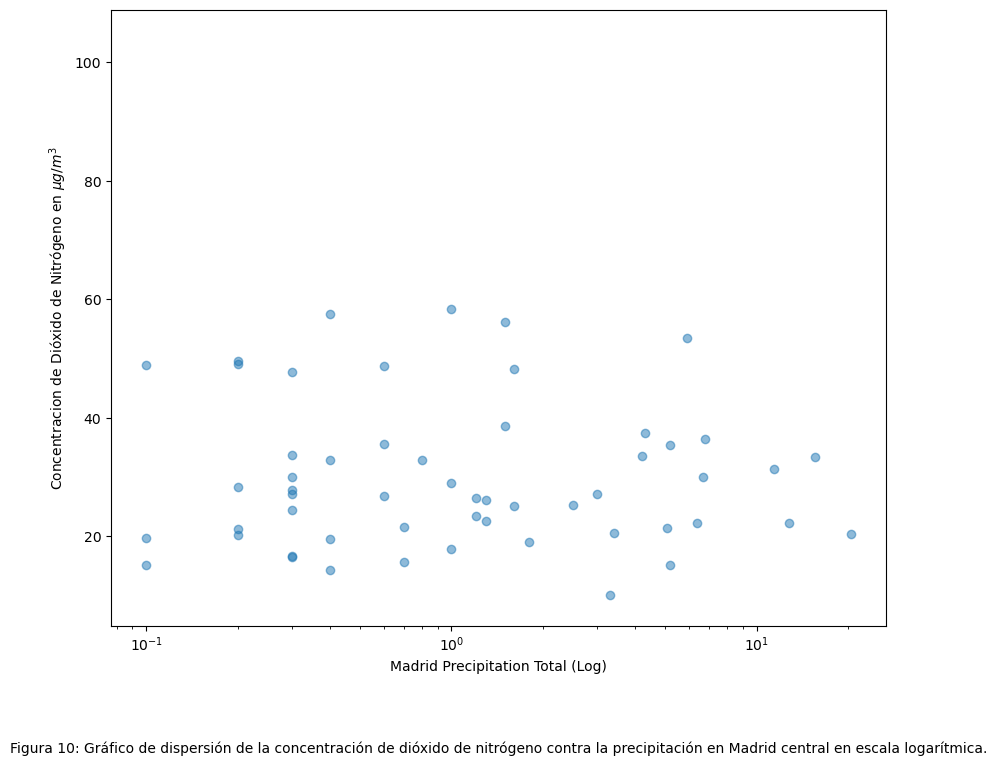

In [144]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

# Gráfico de dispersión
plt.scatter(precip_no2['Madrid Precipitation Total'], precip_no2['media_diaria'], alpha=0.5)

# títulos de eje 
plt.xlabel('Madrid Precipitation Total (Log)')
plt.ylabel('Concentracion de Dióxido de Nitrógeno en ' + r'$\mu g/m^3$')

plt.text(0.5, -0.2, 'Figura 10: Gráfico de dispersión de la concentración'
         ' de dióxido de nitrógeno contra la precipitación en Madrid central en escala logarítmica.',
         ha='center', va='center', transform=plt.gca().transAxes)

# Usamos una escala logarítmica en el eje X porque los valores de la precipitación están bastante cerca de cero 
plt.xscale('log')

plt.show()


Se puede observar que **no hay una relación lineal entre las dos variables.**


Como último intento, vamos a crear una instancia de un algoritmo de soporte de regresión de vectores (SVR) con crossvalización, a la que llamaremos `svr_train_and_predict_with_cv`.

Para la regresión no lineal, SVR aplica el "truco del kernel", que  transforma los datos de entrada en un espacio de mayor dimensión. Esta transformación puede hacer que una relación no lineal parezca lineal en el espacio transformado, lo que permite que el algoritmo encuentre un hiperplano que se ajuste a los datos.

En este caso, si efectivamente existe una relación no lineal entre la precipitación y la concentración de NO2, entonces SVR (con un kernel no lineal apropiado como la Función de Base Radial (RBF)) podría potencialmente modelar esa relación mejor que la simple regresión lineal. Sin embargo, SVR también tiene su propio conjunto de hiperparámetros, como el parámetro de regularización C y los parámetros del kernel, que deben ser ajustados adecuadamente para obtener los mejores resultados.

In [145]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

def svr_train_and_predict_with_cv(train, test):
    X_train = np.array(train['Madrid Precipitation Total']).reshape(-1,1)
    y_train = np.log(train['media_diaria'])
    X_test = np.array(test['Madrid Precipitation Total']).reshape(-1,1)

    # Definir la malla de parámetros
    param_grid = {'C': [0.1, 1, 10, 100], 'epsilon': [0.01, 0.1, 1, 10]}

    # Usar SVR con el kernel RBF
    svr = SVR(kernel='rbf')

    # Usar GridSearchCV
    grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='r2')
    grid_search.fit(X_train, y_train)

    # Imprimir los mejores parámetros
    print('Mejores parámetros: ', grid_search.best_params_)

    # Predecir con el mejor modelo
    y_pred = grid_search.best_estimator_.predict(X_test)

    return np.exp(y_pred)  # devolver a la escala original


In [146]:
ventana_size = 30
predicciones_svr = []

# Ventana rodante
for i in range(ventana_size, len(test_30)):
    train_temp = pd.concat([training_70, test_30.iloc[:i]])
    test_temp = test_30.iloc[i:i+1]
    predicciones_svr.append(svr_train_and_predict_with_cv(train_temp, test_temp))

# Creamos otra vez la lista de predicciones
predicciones_svr = [item for sublist in predicciones_svr for item in sublist]


Mejores parámetros:  {'C': 0.1, 'epsilon': 1}
Mejores parámetros:  {'C': 0.1, 'epsilon': 1}
Mejores parámetros:  {'C': 0.1, 'epsilon': 1}
Mejores parámetros:  {'C': 0.1, 'epsilon': 1}
Mejores parámetros:  {'C': 0.1, 'epsilon': 1}
Mejores parámetros:  {'C': 0.1, 'epsilon': 1}
Mejores parámetros:  {'C': 0.1, 'epsilon': 1}
Mejores parámetros:  {'C': 0.1, 'epsilon': 1}
Mejores parámetros:  {'C': 0.1, 'epsilon': 1}
Mejores parámetros:  {'C': 0.1, 'epsilon': 1}
Mejores parámetros:  {'C': 0.1, 'epsilon': 1}
Mejores parámetros:  {'C': 0.1, 'epsilon': 1}
Mejores parámetros:  {'C': 0.1, 'epsilon': 1}
Mejores parámetros:  {'C': 0.1, 'epsilon': 1}
Mejores parámetros:  {'C': 0.1, 'epsilon': 1}
Mejores parámetros:  {'C': 0.1, 'epsilon': 1}
Mejores parámetros:  {'C': 0.1, 'epsilon': 1}
Mejores parámetros:  {'C': 0.1, 'epsilon': 1}
Mejores parámetros:  {'C': 0.1, 'epsilon': 1}
Mejores parámetros:  {'C': 0.1, 'epsilon': 1}
Mejores parámetros:  {'C': 0.1, 'epsilon': 1}
Mejores parámetros:  {'C': 0.1, 'e

In [147]:
from sklearn.metrics import mean_squared_error, r2_score

y_test = np.array(test_30['media_diaria'][ventana_size:])
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, predicciones_svr)))
print("Test R2 Score: ", r2_score(y_test, predicciones_svr))

Test RMSE:  17.429968316093294
Test R2 Score:  -0.20705805401775268


La puntuación R2 negativa indica que el modelo no está funcionando bien en los datos de prueba. Esto podría deberse a una variedad de factores, incluyendo:

* Los datos podrían contener mucho ruido, lo que dificulta que el modelo aprenda el patrón subyacente. Esto es común en los datos del mundo real.

* O, si la relación entre la precipitación y las concentraciones de NO2 es no lineal o compleja, los modelos lineales o incluso los modelos no lineales simples como SVR podrían no funcionar bien.

* Las características utilizadas para la predicción podrían no contener suficiente información para una predicción precisa. Las características adicionales podrían ayudar a mejorar el rendimiento del modelo.

**Debido al bajo rendimiento de este modelo, debemos afrontar que la precipitación no es la mejor característica o variable para predecir la cantidad de dióxido de nitrógeno en el aire.**

Existen varios factores que pueden influir en la concentración de NO2 en la atmósfera, aparte de la precipitación:

* Velocidad y Dirección del Viento

* Temperatura

* Estacionalidad

* Otras Condiciones Meteorológicascomo la humedad, la presión y la exposición a la luz solar (la radiación UV puede descomponer el NO2) también pueden afectar las concentraciones de NO2.

**Propongo que la continuación de este estudio se lleve a cabo añadiendo estas variables a la base de datos.**
